In [160]:
import numpy as np
from scipy.special import comb
from itertools import combinations
from scipy.io import mmread, mminfo
from os import listdir
from os.path import isfile, join
import time
import pickle
import pandas as pd

### Start of Elimination Ordering.

#### Normalize Stage

In [21]:
'''Normalize Stage'''
'''preliminaries:
- node == vertex ("vertices" for plural)
- nodes' index start at 0
- all graphs and trees are represented in matrix farm
- valency is the sum of the edges' weights of a node, i.e. the sum of the row in a corresponding index, in numpy:
    np.sum(graph[node_idx])
- currently, the matrix is assumed to be symmetric (undirected)
- a fill is only calculated during the elimination, not during the algorithm process to get the elimination ordering,
and a fill is A[i][j] = 1 iff A[i][k] = A[k][i] = A[j][k] = A[k][j] = 1 then A[i][k] = A[k][i] = A[j][k] = A[k][j] = 0
- the diagonal element is always ignored (must be zero'd first if it's nonzero)
- non zeros' values doesn't matter (unweighted), it's always binary (0,1)
'''
'''independent functions:'''

#for transforiming tree matrices to ordered list
def topological_sort_tree(tree_in):
    #look for the "first" node, which is the node with no incoming edges:
    tree = np.copy(tree_in) #copy the tree so the input wont be affected
    size = tree.shape[0]
    S = []
    for i in range(size):
        #need to exclude disconnected nodes by checking row-wise too:
        if np.sum(tree[:,i]) == 0:
            if np.sum(tree[i]) > 0:
                S.append(i)
    #print("S",S)
    
    enque = lambda q, x: q.append(x)
    deque = lambda q: q.pop(0)
    #kahn's algorithm for topological sort (https://en.wikipedia.org/wiki/Topological_sorting):
    #input: tree, first_nodes
    L = []
    while len(S) > 0:
        n = deque(S)
        L.append(n)
        ms = np.where(tree[n] == 1)[0]    #look for set of destination nodesf rom n (neighbours)
        #for each node m with an edge e from n to m:
        for m in ms:
            tree[n][m] = 0 #remove edge e from the graph
            if np.sum(tree[:,m]) == 0: #if m has no other incoming edges then
                enque(S, m) #insert m into S
    #there should be a final check whether the graph still has some edges, but it isnt necessary for tree cases since trees wont have DAG
    return L

#Breadth-First-Search traversal algorithm:
def BFS(graph, source):
    n_init = graph.shape[0]
    q = []
    enque = lambda q, x: q.append(x)
    deque = lambda q: q.pop(0)
    visited = np.array([0]*n_init)
    distances = np.array([0]*n_init)
    visited[source] = 1
    enque(q, source)
    q_counter = 1 #to keep track how many neighbours enqueued
    path = []
    while q:
        v = deque(q)
        q_counter = q_counter - 1
        neighbours = np.where(graph[v] == 1)[0] #enque all v's neighbours (gamma(v))
        for node_i in neighbours:
            if (visited[node_i] == 0) and (node_i not in q):
                enque(q, node_i)
                visited[node_i] = 1
                q_counter += 1
        #print(v, neighbours, q, q_counter, depth)
        path.append(v)
    return path

#get ordered list from merge forest
def get_ordered_list_merged_vertex(tree, placed_vertex):
    '''algorithm for tree-tracing that covers all scenarios:
    0. transpose the tree (to get the reverse order), due to the nature of the merge procedure, the leaves will be the roots
    1. topological sort to get the root(s)
    2. determine the roots by checking the connections between vertices
    3. if there are more than one roots:
        BFS traverse starting from the placed node to get the ordered lists
    else:
        just use the list from the topological sort as the ordered list
    '''
    #print("edges:", np.where(tree.T == 1))
    topological_list = topological_sort_tree(tree.T)
    #print("topological_list",topological_list)
    '''
    print("topological_list",topological_list)
    print(tree)
    print(tree.T)
    '''
    #check the number of roots and get the corresponding roots:
    length = len(topological_list)
    roots = [topological_list[0]]
    for i_elem in topological_list:
        non_root_found = False
        for j_elem in topological_list:
            if i_elem != j_elem:
                if tree.T[i_elem][j_elem] == 0:
                    #print(i_elem, j_elem)
                    roots.append(j_elem)
                else:
                    non_root_found = True
                    break
        if non_root_found:
            break
    #print("roots",roots)
    #if more than one roots, do BFS starting from the placed node, else just use the topological_list:
    ordered_list = None
    #print("ordlist bfs reversed:",list(reversed(BFS(tree, placed_vertex))))
    if len(roots) > 1:
        #ordered_list = BFS(tree.T, placed_vertex)
        ordered_list = list(reversed(BFS(tree, placed_vertex)))
        #print("orderedlist bfs",ordered_list)
    else:
        ordered_list = topological_list
        #print("orderedlist",topological_list)
    #print("ordered_list",ordered_list)
    return ordered_list

#clique checker:
def clique_check(graph, vertices_idx):
    #get subgraph, by slicing indexes:
    subgraph = graph[vertices_idx][:,vertices_idx]
    n = subgraph.shape[0]
    #check for clique from subgraph:
    upper_tri = subgraph[np.triu_indices(n, 1)]
    return np.sum(upper_tri) == comb(n, 2)

#subset checker:
def check_subset(graph, neighbours):
    bool_subset = False
    j_get = None
    for j_node in neighbours:
        #probably need to be stopped earlier? instead of taking the last neighbour index
        gamma_j = np.where(graph[j_node] == 1)[0]
        j_T = np.append(gamma_j, j_node) #j^up_tack = j union gamma(j):= j added to its neighbours
        if set(neighbours).issubset(set(j_T)): #gamma(i) \subset j^up_tack
            bool_subset = True
            j_get = j_node
            break #stop when found
    return bool_subset, j_get

#more accurate way of checking the total nodes within a graph, since the edge is represented 
#by the value of A[i][j] cell, e.g if i <-> j is connected, it means A[i][j] = A[j][i] 1, otherwise 0, 
#so the size of the matrix may not correspond to the total number of nodes
def get_total_nodes(graph, row_size):
    counter = 0
    for i in range(row_size):
        if np.sum(graph[i]) > 0:
            counter += 1
    return counter

'''end'''


def initialize(graph):
    '''function for data initialization, returns:
    - e vector placeholder
    - weight vector w
    - empty merge forest
    - first zero and last zero idxes
    - deleted bool array
    '''
    n = graph.shape[0]
    e = np.array([-1]*n) #for now the placeholder is an array of -1
    w = np.array([1]*n) #weight vector for merge forest
    merge_forest = np.zeros((n,n)) #merge forest for assessment criteria
    deleted = np.array([False]*n)
    first_zero = 0; last_zero = -1
    return e, w, first_zero, last_zero, merge_forest, deleted

#normalize stage:
def normalize(graph):
    global deleted, e, w, first_zero, last_zero, merge_forest
    n = n_init = graph.shape[0] #number of nodes
    '''e = np.array([-1]*n) #for now the placeholder is an array of -1
    w = np.array([1]*n) #weight vector for merge forest
    merge_forest = np.zeros((n,n)) #merge forest for assessment criteria'''
    modified = np.array([1]*n) #modified = 1, otherwise 0'''


    #normalize stage
    #for now, cyclic ordering assumption: start from the 1st index to last idx, hence for-loop
    #need merge check for every node passed, by w[i] > 1
    #print("i, n, m, valency, e, summodified, firstzero, lastzero")
    while np.sum(modified) > 0:
        #print()
        #for i in range(n_init):
        for i in range(n_init):
            #check if it is already deleted, if yes, skip:
            if deleted[i]: #deleted in prev round
                modified[i] = 0 #set modified to 0
                #print("already deleted:",i)
                continue
            if np.sum(modified) == 0:
                break
            #recalculate all of the values:
            n = get_total_nodes(graph, n_init) #recalculate n by excluding zero vectored rows (disconnected vertices)
            valencies = np.array([np.sum(graph[j]) for j in range(n_init)]) #needs to recalculate the valency for each update due to the graph-change
            #print(i,n,m,valency,valencies,e,modified)
            mean_valency = np.sum(valencies)/n #get mean valency
            max_valency = np.max(valencies) #get max valency
            valency = np.sum(graph[i]) #get vertex's valency
            m = np.min([mean_valency, np.floor(n**(1/4) + 3)])
            #m = np.floor(n**(1/4) + 3) #probably this is the correct interpretiation
            #print("mean_valency, np.floor(n**(1/4) + 3)",mean_valency, np.floor(n**(1/4) + 3))
            neighbours = np.where(graph[i] == 1)[0] #get the neighbours of i
            #print(i,n,m,valency,e,np.sum(modified),first_zero, last_zero)
            #print("neighbours",neighbours)
            #check all of the conditions based on the valency
            if valency == n-1:
                ##always check for merge - i.e w[i] > 1
                if w[i] > 1:
                    ordered_list = get_ordered_list_merged_vertex(merge_forest, i)
                    len_e = len(e)
                    len_ord_list = len(ordered_list)
                    e[len_e + last_zero - len_ord_list + 1 : len_e + last_zero + 1] = ordered_list #lastzero placement
                    last_zero -= len_ord_list #decrement last zero by the size of the ordered list 
                else:
                    #add to the last zero and decrement the indexer:
                    e[last_zero] = i
                    last_zero -= 1
                graph[i] = graph[:,i] = 0  #remove from graph by deleting edges
                deleted[i] = True
                #graph = np.delete(graph, i, 0) #delete from graph -- this should be the proper deletion method, though not sure if it's faster
                #graph = np.delete(graph, i, 1)
                modified[neighbours] = 1 #set neighbours as modified
                #print("rule 1")
            elif (valency > np.ceil(n/2)) and (valency == max_valency):
                if w[i] > 1:
                    ordered_list = get_ordered_list_merged_vertex(merge_forest, i)
                    len_e = len(e)
                    len_ord_list = len(ordered_list)
                    e[len_e + last_zero - len_ord_list + 1 : len_e + last_zero + 1] = ordered_list
                    last_zero -= len_ord_list
                else:
                    e[last_zero] = i
                    last_zero -= 1
                graph[i] = graph[:,i] = 0
                deleted[i] = True
                modified[neighbours] = 1
                #print("rule 2")
            elif valency <= 1:
                #e.insert(0, i) #place vertex first
                if w[i] > 1:
                    ordered_list = get_ordered_list_merged_vertex(merge_forest, i)
                    len_e = len(e)
                    len_ord_list = len(ordered_list)
                    e[first_zero : first_zero + len_ord_list] = ordered_list #insert by firstzero pos
                    first_zero += len_ord_list #increment the first zero by the size of the ordered list
                else:
                    #add to the first zero pos and increment the indexer:
                    e[first_zero] = i
                    first_zero += 1
                graph[i] = graph[:,i] = 0
                deleted[i] = True
                modified[neighbours] = 1
                #print("rule 3")
            elif valency == 2:
                #e.insert(0, i)
                if w[i] > 1:
                    ordered_list = get_ordered_list_merged_vertex(merge_forest, i)
                    len_e = len(e)
                    len_ord_list = len(ordered_list)
                    e[first_zero : first_zero + len_ord_list] = ordered_list #insert by firstzero pos
                    first_zero += len_ord_list
                else:
                    #add to the first zero pos and increment the indexer:
                    e[first_zero] = i
                    first_zero += 1
                graph[neighbours[0]][neighbours[1]] = graph[neighbours[1]][neighbours[0]] = 1 #make edge between them -- fill the value of the cell with 1
                graph[i] = graph[:,i] = 0
                deleted[i] = True
                modified[neighbours] = 1
                #print("rule 4")
            elif (valency <= m) and (clique_check(graph, neighbours)):
                #e.insert(0, i)
                if w[i] > 1:
                    ordered_list = get_ordered_list_merged_vertex(merge_forest, i)
                    #print("tree[i]",np.where(merge_forest[i] == 1))
                    len_e = len(e)
                    len_ord_list = len(ordered_list)
                    e[first_zero : first_zero + len_ord_list] = ordered_list #insert by firstzero pos
                    first_zero += len_ord_list
                    #print("place multiple nodes",ordered_list)
                else:
                    #add to the first zero pos and increment the indexer:
                    #print("place one node")
                    e[first_zero] = i
                    first_zero += 1
                graph[i] = graph[:,i] = 0
                deleted[i] = True
                modified[neighbours] = 1
                #print("rule 5")
            elif (valency <= m): 
                bool_subset, j_node = check_subset(graph, neighbours) #gamma(i) \subset j^uptack, j \in gamma(i)
                if bool_subset:
                    merge_forest[j_node][i] = 1 #merge i into j, add directed edge j->i
                    w[j_node] += 1 #increment weight
                    graph[i] = graph[:,i] = 0
                    deleted[i] = True
                    modified[neighbours] = 1
                    #print("rule 6")
                    #print(neighbours, modified[neighbours])
                    #print("merged",i,j_node)
            modified[i] = 0 #set vertex as unmodified
            #print("w,deleted",w[i],np.where(deleted == True)[0])
            #print()
    #return e, w, first_zero, last_zero, merge_forest
    #return first_zero, last_zero

In [38]:
'''merge-forest placement test'''
dummy_order = np.array([7,9,8,-1,-1,-1,-1,-1,5,6])
dummy_placed = 3
dum_fz = 3
dum_lz = -3

#topological sort:
t = np.array([[0,0,1,0,0], #0-2,1-3,4-2
              [0,0,0,1,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,1,0,0]
             ])
'''
t = np.array([[0,1,0,0],
              [0,0,1,0],
              [0,0,0,1],
              [0,0,0,0]])
'''


ordered_list = get_ordered_list_merged_vertex(t, dummy_placed)
print(dummy_order,ordered_list)
#place first:
length = len(ordered_list)
length_do = len(dummy_order)
print(length_do, length)
dummy_order[dum_fz : dum_fz + length] = ordered_list #firstzero placement
print(length_do + dum_lz - length, length_do + dum_lz + 1) #5,8
dummy_order[length_do + dum_lz - length + 1: length_do + dum_lz + 1] = ordered_list #lastzero placement
print(dummy_order)

S [2, 3]
[ 7  9  8 -1 -1 -1 -1 -1  5  6] [3, 1]
10 2
5 8
[ 7  9  8 -1 -1 -1  3  1  5  6]


In [177]:
'''graphs collection for normalization testing'''
#test array/graph from https://people.sc.fsu.edu/~jburkardt/m_src/rcm/rcm.html
graph = np.array([
            [0, 0, 1, 0, 0, 0, 0, 1, 1],
            [0, 0, 1, 0, 0, 1, 1, 1, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 1, 1, 0, 0, 0, 0],
            [1, 0, 0, 1, 0, 0, 0, 0, 0]
             ])
print(graph)

#nauru graph
graph_1 = np.zeros((24,24))
graph_1[0][1] = graph_1[0][5] = graph_1[0][21] = \
graph_1[1][3] = graph_1[1][15] = \
graph_1[2][3] = graph_1[2][4] = graph_1[2][23] = \
graph_1[3][9] = graph_1[4][5] = graph_1[4][17] = \
graph_1[5][11] = graph_1[6][7] = graph_1[6][11] = graph_1[6][19] = \
graph_1[7][9] = graph_1[7][13] = \
graph_1[8][9] = graph_1[8][10] = graph_1[8][22] = \
graph_1[10][11] = graph_1[10][16] = \
graph_1[12][13] = graph_1[12][17] = graph_1[12][18] = \
graph_1[13][15] = graph_1[14][15] = graph_1[14][16] = graph_1[14][20] = \
graph_1[16][17] = graph_1[18][19] = graph_1[18][23] = \
graph_1[19][21] = graph_1[20][21] = graph_1[20][22] = \
graph_1[22][23] = 1
graph_1 += graph_1.T
print(np.allclose(graph_1, graph_1.T, rtol=1e-05, atol=1e-08))

'''testing-ground for normalize stage'''
e, w, first_zero, last_zero, merge_forest, deleted = initialize(graph)
print(normalize(graph))
print("e, w, first_zero, last_zero, merge_forest, deleted",e, w, first_zero, last_zero, merge_forest, deleted)

e, w, first_zero, last_zero, merge_forest, deleted = initialize(graph_1)
print(normalize(graph_1))
print("e, w, first_zero, last_zero, merge_forest, deleted",e, w, first_zero, last_zero, merge_forest, deleted)


[[0 0 1 0 0 0 0 1 1]
 [0 0 1 0 0 1 1 1 0]
 [1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 1 0 0]
 [0 1 0 0 1 1 0 0 0]
 [1 1 0 1 1 0 0 0 0]
 [1 0 0 1 0 0 0 0 0]]
True
None
e, w, first_zero, last_zero, merge_forest, deleted [2 3 4 5 6 8 1 0 7] [1 1 1 1 1 1 1 1 1] 7 -3 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]] [ True  True  True  True  True  True  True  True  True]
None
e, w, first_zero, last_zero, merge_forest, deleted [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 0 -1 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in long_scalars


In [176]:
"""testing the merge rule (r6) using banded matrix"""
graph_2 = np.array([[0,1,1,1,0,0,0],
                    [1,0,1,1,1,0,0],
                    [1,1,0,1,1,1,0],
                    [1,1,1,0,1,1,1],
                    [0,1,1,1,0,1,1],
                    [0,0,1,1,1,0,1],
                    [0,0,0,1,1,1,0]
                   ])
print("g2:")
print("symm", np.allclose(graph_2, graph_2.T, rtol=1e-05, atol=1e-08))
print("clique", clique_check(graph_2, [1,2,3]))
print("1^up_tack", check_subset(graph_2, [1,2,3]))
e, w, first_zero, last_zero, merge_forest, deleted = initialize(graph_2)
print(normalize(graph_2))


graph_3 = np.array([[0,1,1,1],
                    [1,0,1,0],
                    [1,1,0,1],
                    [1,0,1,0]])
print("g3:")
print("clique", clique_check(graph_3, [1,2,3]))
print("1^up_tack", check_subset(graph_3, [1,2,3]))

#test using another bamded matrix
from scipy.sparse import diags
graph_4 = diags([1,1,1, 1, 0, 1, 1,1,1], [-4,-3,-2,-1, 0, 1,2,3,4], shape=(8, 8), dtype=int).toarray()
print("g4:")
print(graph_4)
print("clique", clique_check(graph_4, [1,2,3]))
print("1^up_tack", check_subset(graph_4, [1,2,3]))
e, w, first_zero, last_zero, merge_forest, deleted = initialize(graph_4)
print(normalize(graph_4))

g2:
symm True
clique True
1^up_tack (True, 1)
None
g3:
clique False
1^up_tack (True, 2)
g4:
[[0 1 1 1 1 0 0 0]
 [1 0 1 1 1 1 0 0]
 [1 1 0 1 1 1 1 0]
 [1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 1 1]
 [0 1 1 1 1 0 1 1]
 [0 0 1 1 1 1 0 1]
 [0 0 0 1 1 1 1 0]]
clique True
1^up_tack (True, 1)
None


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in long_scalars


#### Separation Stage

In [22]:
'''dijkstra https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm''' 
#function to help djikstra algorithm:
def get_min_distance_vertex(Q, distances):
    min_dist = float("inf")
    min_v = None
    for v in range(Q.shape[0]):
        if (distances[v] < min_dist) and (Q[v] == 1):
            min_dist = distances[v]
            min_v = v
    return min_dist, min_v

#start of dijkstra algorithm:
def dijkstra_shortest_path(graph, source):
    #n_init = get_total_nodes(graph, graph.shape[0])
    n_init = graph.shape[0]
    Q = np.array([1]*n_init)
    #print(Q)
    #source = root = 0
    distances = np.array([float("inf")]*n_init) #set distance vector
    distances[source] = 0
    prev = np.array([None]*n_init)

    while np.sum(Q) > 0:
        _, u = get_min_distance_vertex(Q, distances) #get the vertex with minimum distance
        Q[u] = False #remove u from Q
        neighbours = np.where(graph[u] == 1)[0]
#        print("len(Q), neighbours",len(Q), neighbours)
        for v in neighbours:
            if Q[v] == 1:
                alt = distances[u] + graph[u][v] #distance is equal to the weight of the edge between u and v
                if alt < distances[v]:
                    distances[v] = alt
                    prev[v] = u
                #print(alt)
    return distances, prev

#function to find max valency from nodes
def get_max_valency(subset_nodes, valencies):
    max_valency = -float("inf")
    max_vertex = None
    for m in subset_nodes:
        if valencies[m] > max_valency:
            max_valency = valencies[m]
            max_vertex = m
    return max_vertex, max_valency

'''Separate Stage'''
def separate(graph):
    global deleted, e, w, first_zero, last_zero, merge_forest
    n_init = graph.shape[0] #actual graph size
    
    '''RCM part'''
    #1, d=0, pick vertex e with max valency:
    #print("#1: ")
    d_prime = 0
    n_nodes = get_total_nodes(graph, graph.shape[0]) #current total nodes
    valencies = np.array([np.sum(graph[i]) for i in range(n_init)])
    e_sep = np.argmax(valencies) #get the node with max valency

    #2, need to find a set of M with max distansce from e, which requires BFS or djikstra:
    #print("#2: ")
    distances, _ = dijkstra_shortest_path(graph, e_sep)
    #print("distances",distances)
    conn_components = np.where(distances != np.inf)[0] #indexes of connected components within the subgraph where e resides
    conn_distances = distances[conn_components] #distances of connected components (distances excluding inf)
    s = conn_components.shape[0] #total connected components
    d = np.max(conn_distances) #max distance from e
    M = np.where(distances == d)[0] #set of vertices with max distance from e
    #print("n_init, valencies, e_sep, s, d, M, conn_distances")
    #print(n_init, valencies, e_sep, s, d, M, conn_distances)
    
    
    #3, if d'>d, d'=d, pick a vertex from M with max valency, back to 2 if the first e is close to the second e
    #print("#3: ")
    loopcount = 0 #for repetition statistics
    while d>d_prime:
        #print("d, d_prime, e_sep",d, d_prime, e_sep)
        d_prime = d
        max_vertex,_ = get_max_valency(M, valencies)
        #print("M, valencies",M, valencies)
        e_sep = max_vertex

        #do 2 again:
        distances, _ = dijkstra_shortest_path(graph, e_sep)
        conn_components = np.where(distances != np.inf)[0] #indexes of connected components within the subgraph where e resides
        conn_distances = distances[conn_components] #distances of connected components (distances excluding inf)
        s = conn_components.shape[0] #total connected components
        d = np.max(conn_distances) #max distance from e
        M = np.where(distances == d)[0] #set of vertices with max distance from e
        loopcount+=1
    #print("RCM loopcount", loopcount)
    #print("n_init, valencies, e_sep, s, d, M, conn_distances")
    #print(n_init, valencies, e_sep, s, d, M, conn_distances)
    '''end of RCM'''

    
    #3.5, get the n_k from e, 0<=k<=d, d=max distance, k \in Z
    #print("#3.5: n_k from e, 0<=k<=d, d=max distance")
    max_d = np.max(conn_distances).astype(int)
    n_arr = np.zeros(max_d+1)
    for i in range(0,max_d+1):
        n_arr[i] = np.where(conn_distances == i)[0].shape[0]
    #print("n_arr",n_arr)
    
    
    #4, initialization of several variables:
    ##NOTE: there are two n's, n_k and n_{k+1}, which will be used for comparison in a condition.
    #print("#4: ")
    k=0; N=[np.array([e_sep])]; n=[1]; u = s-1; tried = np.array([0]*n_init); tried[e_sep] = 1
    
    seploop = 0
    while True:
        #first line:
        #gamma_{k+1}(e):=get neighbours/set of points from e with the distance of k+1
        N_next = np.where(distances == k+1)[0] #get the set of neighbours with distance = k+1
        N.append(N_next)
        n.append(len(N[k+1])) #or sum of weights?
        u -= n[k+1]
        #print("k,N,n,u",k,N,n,u)

        #print("n_arr[k] <= n_arr[k+1] < n_arr[k+2]",n_arr[k] <= n_arr[k+1] < n_arr[k+2])
        
        #print("k+2, len(n_arr), d",k+2, len(n_arr), d)
        '''if k+2 < len(n_arr): #temporary fix, by skipping the block if k+2 >= len(n)
            if (n_arr[k] <= n_arr[k+1] < n_arr[k+2]):
                k += 1
                continue'''
        if (k < d-1) and (n_arr[k] <= n_arr[k+1] < n_arr[k+2]) and (u > 0.4*s): #another fix, by adding more skip-conditions
            #print("(k < d-1) and (n_arr[k] <= n_arr[k+1] < n_arr[k+2]) and (u > 0.4*s) condition reached")
            k += 1
            continue
        
        #second line, determining "in degrees":
        #c = {} #need to know which c corresponds to which node, so probably use a dictionary
        c = np.zeros(n_init)
        j_idxs = N[k+1] #to keep track the used node indexes
        for node_j in N[k+1]: #indexing not by nodes' indices, but by c's internal index
            gamma_j = np.where(graph[node_j] == 1)[0]
            c[node_j] = (np.intersect1d(gamma_j, N[k])).shape[0]
            #print("gamma_j, N[k]",gamma_j, N[k])
        #print("c[j_idxs]",c[j_idxs])

        #third line, determining the "out-weights" (weights from normalization stage):
        #b = {} #same reason with c
        b = np.zeros(n_init)
        i_idxs = N[k]
        for node_i in N[k]:
            gamma_i = np.where(graph[node_i] == 1)[0]
            out_w_nodes = np.intersect1d(gamma_i, N[k+1])
            b[node_i] = np.sum(w[out_w_nodes]) #w = weights from normalization, need to know which value belongs to which
            #print("gamma_i, N[k+1]",gamma_i, N[k+1])
        #print("b",b)
        
        
        #fourth line:
        while n[k] > 0:
            #print("n[k]>0",n[k] > 0)
            if (u > 0.4*s) and (n[k+1] < n[k]): #threshold = 0.4s
                #print("(u > 0.4*s) and (n[k+1] < n[k])",(u > 0.4*s) and (n[k+1] < n[k]))
                break
            #place i with largest b_i last: (the rule should follow the placement rule in normalization)
            #new condition to check, when b_i = 0, then break:
            if np.sum(b) == 0:
                #print("b_i all zero")
                #print("k,d,b,c",k,d,b,c)
                break
            #
            placed = np.argmax(b)
            #print("placed",placed)
            ##start of temporary fix
            #if b[placed] > 0: #meaning, gamma(i) \intersect N_{k+1} is not {}
            if w[placed] > 1:
                ordered_list = get_ordered_list_merged_vertex(merge_forest, placed)
                len_e = len(e)
                len_ord_list = len(ordered_list)
                e[len_e + last_zero - len_ord_list + 1 : len_e + last_zero + 1] = ordered_list
                last_zero -= len_ord_list
            else:
                e[last_zero] = placed
                last_zero -= 1
            graph[placed] = graph[:,placed] = 0
            deleted[placed] = True
            b[placed] = 0 #remove from b
            #print("e,fz,lz after placement:",e,first_zero,last_zero)
            #decrement s, n_k, c_j:
            #print("s,n[k],c",s,n[k],c)
            s -= 1; n[k] -= 1; c[N[k+1]] -= 1
            ##end of temporary fix#
            #print("s,n[k],c",s,n[k],c)
            #if c_j == 0: ......
            #drop c_j from N; incr u; decr n[k+1]:
            for node_j in N[k+1]:
                if c[node_j] == 0:
                    N[k+1] = N[k+1][N[k+1] != node_j] #drop cj from N
                    u += 1; n[k+1] -= 1
                    #print("N, u, n, c[node_j]",N, u, n, c[node_j])
        if n[k] == 0: ##NOTE: this part is a little bit uncanny, since in first iter the n[k] will always reach 0
            break
        tried[N[k]] = 1; k += 1 #mark all i \in N_k as tried, increment k
        seploop+=1
        #print("\n seploop",seploop)

    #print(e)
    #return graph, e, w, first_zero, last_zero, merge_forest
    return first_zero, last_zero
            #break #for loop breaking purpose during tests -- removed on actual scenario
        #break #for loop breaking purpose during tests -- removed on actual scenario

'''dummy data'''
graph = np.array([
            [0, 0, 1, 0, 0, 0, 0, 1, 1],
            [0, 0, 1, 0, 0, 1, 1, 1, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 1, 1, 0, 0, 0, 0],
            [1, 0, 0, 1, 0, 0, 0, 0, 0]
             ])

#nauru graph (bipartite)
graph_1 = np.zeros((24,24))
graph_1[0][1] = graph_1[0][5] = graph_1[0][21] = \
graph_1[1][3] = graph_1[1][15] = \
graph_1[2][3] = graph_1[2][4] = graph_1[2][23] = \
graph_1[3][9] = graph_1[4][5] = graph_1[4][17] = \
graph_1[5][11] = graph_1[6][7] = graph_1[6][11] = graph_1[6][19] = \
graph_1[7][9] = graph_1[7][13] = \
graph_1[8][9] = graph_1[8][10] = graph_1[8][22] = \
graph_1[10][11] = graph_1[10][16] = \
graph_1[12][13] = graph_1[12][17] = graph_1[12][18] = \
graph_1[13][15] = graph_1[14][15] = graph_1[14][16] = graph_1[14][20] = \
graph_1[16][17] = graph_1[18][19] = graph_1[18][23] = \
graph_1[19][21] = graph_1[20][21] = graph_1[20][22] = \
graph_1[22][23] = 1
graph_1 += graph_1.T
#print(np.allclose(graph_1, graph_1.T, rtol=1e-05, atol=1e-08))
graph = graph_1

'''
graph = np.array([[0,1,1,1,0,0,0],
                    [1,0,1,1,1,0,0],
                    [1,1,0,1,1,1,0],
                    [1,1,1,0,1,1,1],
                    [0,1,1,1,0,1,1],
                    [0,0,1,1,1,0,1],
                    [0,0,0,1,1,1,0]
                   ])
'''

'''n_init = graph.shape[0]
w = np.array([1]*n_init)
first_zero = 0; last_zero = -1
e = np.zeros(n_init)'''
e,w,first_zero, last_zero, merge_forest, deleted = initialize(graph) 
'''end of dummy data'''

separate(graph)
print("e,w,first_zero, last_zero, merge_forest, deleted: \n",e,w,first_zero, last_zero, merge_forest, np.where(deleted == True))

e,w,first_zero, last_zero, merge_forest, deleted: 
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 18 10  1  3] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 0 -5 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

### Utilities

In [23]:
def eliminate(graph, elimination_order, join_tree=False):
    '''elimination function: eliminates the vertices based on the order resulted from elimination ordering algorithms
    - takes in the vertices order from the any elimination ordering algorithms (e.g. METIS' nested dissection)
    - fill will be added when the "center" of the vertex is eliminated, e.g., 1-2-3, eliminate 2, fill(1-3), fill_count+=1
    - for now, assume the fill will be comb(n,2), so if there are 3 vertices which depend on an eliminated vertex, there will be 6 fills
    - if join_tree = True, then the procedure of generating C_v and separator indexes for join tree will be executed, otherwise it will be skipped
    '''
    count_fill = 0
    if join_tree:
        C_vs = []
        sep_idxs = []
    for v in elimination_order:
        #find neighbours and fill the fill-in indexes:
        K_v = np.where(graph[v] == 1)[0]
        #C_v = np.union1d(v, K_v)
        if join_tree:
            C_v = np.array([v] + [w for w in K_v])
            sep_idx = 0 #separator index of (J|K), e.g. 5|29, meaning sepidx = 0; 52|9, meaning sepidx = 1
            C_vs.append(C_v); sep_idxs.append(sep_idx)
        fill_idxs = list(combinations(K_v, 2))
        if len(fill_idxs) > 0:
            for fill in fill_idxs:
                if graph[fill[0]][fill[1]] == 0:
                    graph[fill[0]][fill[1]] = graph[fill[1]][fill[0]] = 1
                    count_fill += 1
        graph[v] = graph[:,v] = 0 #eliminate v
    return_data = None
    if join_tree:
        return_data = (count_fill, graph, C_vs, sep_idxs) 
    else:
        return_data = (count_fill, graph)
    return return_data


def absorption(e, C_vs, sep_idxs):
    '''absorption method, takes in elimination ordering, C_v and separator indexes'''
    length = len(e)
    absorbed = np.array([False]*length)
    for i in range(length):
        #print("C_vs[i]", C_vs[i])
        for j in range(i, length): #absorb into the earliest:
            if (set(C_vs[j]) < set(C_vs[i])) and (absorbed[j] == False): #check if C_v[j] is in C_v[i]
                sep_idxs[i] += sep_idxs[j]+1 #move separator of i by sep_idx[j]+1
                absorbed[j] = True #delete C_v[j] by marking it as "abvsorbed"

    C_vs = np.array(C_vs)
    C_vs = np.delete(C_vs, np.where(absorbed == True)[0])
    sep_idxs = np.delete(sep_idxs, np.where(absorbed == True)[0])
    #print(C_vs, sep_idxs)
    #calculate C_v and K_v sizes:
    length = C_vs.shape[0]
    C_sizes = np.array([C_v.shape[0] for C_v in C_vs]) 
    K_sizes = np.array([C_sizes[i]-sep_idxs[i]-1 for i in range(length)]) #K_size = C_size - sep_idx - 1
    max_C = np.max(C_sizes)
    max_K = np.max(K_sizes)
    return C_sizes, K_sizes, max_C, max_K

def adj_mat_to_metis_file(graph, filename):
    '''write adjacency matrix to file'''
    first_line = np.array([graph.shape[0], int(np.sum(graph)/2)]) #[nodes, edges]
    adj_list = []
    for i in range(graph.shape[0]):
        neighbours = np.where(graph[i] == 1)[0]
        neighbours += 1
        adj_list.append(neighbours)
    adj_list = np.array(adj_list)
    
    with open(filename,"w") as f:
        f.write(str(first_line[0])+" "+str(first_line[1])+"\n")
        for i in range(adj_list.shape[0]):
            for j in range(adj_list[i].shape[0]):
                f.write(str(adj_list[i][j])+" ")
            f.write("\n")
    print("writing",filename,"done!")

def iperm_to_orderlist(filename):
    '''read iperm from ndmetis and convert it to list'''
    f = open(filename, "r")
    order = []
    for x in f:
        order.append(int(x))
    order = np.array(order)
    #according to metis documentatoin:
    actual_order = np.zeros(order.shape[0])
    for i in range(order.shape[0]):
        actual_order[i] = np.where(order == i)[0]
    actual_order = actual_order.astype(np.int64, copy=False)
    return actual_order

def load_matrix_market(filename, get_mat_meta=False):
    '''test using matrices from matrix market'''
    #filename = "matrices/bcsstm01.mtx.gz"
    metadata = mminfo(filename)
    Matrix = mmread(filename)
    A = Matrix.toarray()
    #print(A)
    #print(np.nonzero(A))
    '''preprocess the matrix'''
    A = A.astype(np.int64, copy=False)
    '''    
    #symmetrize the matrix:
    A = A + A.T
    #print("symmetrize:")
    #print(A)
    #set diagonals to zero:
    np.fill_diagonal(A, 0)
    #print("diag")
    #print(A)
    #if a nonzero element is >0 or <0, set it to 1:
    #print("nz")
    A[np.nonzero(A)] = 1
    #print(A)
    '''
    if get_mat_meta:
        return A, metadata
    else:
        return A

def bipartization(G):
    '''square -> bipartite'''
    A = np.copy(G)
    len_A = A.shape[0]
    B = np.zeros([len_A*2, len_A*2])
    len_B = B.shape[0]
    B[:len_A,len_A:len_B] = A #top right
    B.T[:len_A,len_A:len_B] = A #bottome left
    B[np.nonzero(B)] = 1
    return B    
    
def symmetrization(G):
    '''square -> symmetric'''
    A = np.copy(G)
    #symmetrize the matrix:
    A = A + A.T
    #set diagonals to zero:
    np.fill_diagonal(A, 0)
    #if a nonzero element is >0 or <0, set it to 1:
    #print("nz")
    A[np.nonzero(A)] = 1
    return A

def grid_generator(p, q, k, p_dep=0, q_dep=0):
    '''p*q grid generator, p = row, q = col
    if p_dep = 1: p=q,
    elif p_dep = 2: p=q**2
    else p is an input parameter
    if q_dep = 1: q = 2**k
    else q is an input parameter
    '''
    if q_dep == 1:
        q = 2**k
    if p_dep == 1:
        p = q
    elif p_dep == 2:
        p = q**2
    print('p,q,k',p,q,k)
    grid = np.zeros((p*q, p*q)) #grid matrix
    diag = np.ones(q)
    sub_grid = np.zeros((q,q))
    np.fill_diagonal(grid[q:], diag) #lower diagonal main grid
    np.fill_diagonal(grid[:,q:], diag) #upper diagonal main grid
    np.fill_diagonal(sub_grid[1:], diag) #lower diagonal for subgrid
    np.fill_diagonal(sub_grid[:,1:], diag) #upper diagonal for subgrid
    for i in range(p):
        grid[i*q:(i*q)+q, i*q:(i*q)+q] = sub_grid
    return grid

graph = np.array([
            [0, 0, 1, 0, 0, 0, 0, 1, 1],
            [0, 0, 1, 0, 0, 1, 1, 1, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 1, 1, 0, 0, 0, 0],
            [1, 0, 0, 1, 0, 0, 0, 0, 0]
             ])
order = [2, 3, 4, 5, 6, 8, 1, 0, 7] #from the elimination ordering result
countfill,_ = eliminate(graph, order)
print("total fill:" ,countfill)

#banded matrix 2m+1 = 15
graph_2 = np.array([[0,1,1,1,0,0,0],
                    [1,0,1,1,1,0,0],
                    [1,1,0,1,1,1,0],
                    [1,1,1,0,1,1,1],
                    [0,1,1,1,0,1,1],
                    [0,0,1,1,1,0,1],
                    [0,0,0,1,1,1,0]
                   ])
order = [0, 1, 2, 6, 5, 4, 3]
countfill,_ = eliminate(graph, order)
print("total fill:" ,countfill)


total fill: 3
total fill: 0


### Combining both normalize and separate stage

In [24]:
def elimination_ordering(graph, log=False):
    #alternate normalize and separate while the graph is not empty
    i=0
    while np.sum(graph) > 0:
        if np.sum(graph) == 0:
            break
        if log:
            print("Normalize:")
        normalize(graph)
        if log:
            print("e, w, first_zero, last_zero, deleted", e, w, first_zero, last_zero, np.where(deleted == True))
        if np.sum(graph) == 0:
            break
        if log:
            print("\n Separate:")
        separate(graph)
        if log:
            print("e, w, first_zero, last_zero, deleted \n", e, w, first_zero, last_zero, np.where(deleted == True))
        #print(graph, merge_forest)
        if log:
            print("==================NEW ROUND======================= \n")
        print("stage iteration:",i)
        i += 1
    return e


'''input data: '''
'''graph = np.array([
            [0, 0, 1, 0, 0, 0, 0, 1, 1],
            [0, 0, 1, 0, 0, 1, 1, 1, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 1, 1, 0, 0, 0, 0],
            [1, 0, 0, 1, 0, 0, 0, 0, 0]
             ])'''
#nauru graph (bipartite)
graph_1 = np.zeros((24,24))
graph_1[0][1] = graph_1[0][5] = graph_1[0][21] = \
graph_1[1][3] = graph_1[1][15] = \
graph_1[2][3] = graph_1[2][4] = graph_1[2][23] = \
graph_1[3][9] = graph_1[4][5] = graph_1[4][17] = \
graph_1[5][11] = graph_1[6][7] = graph_1[6][11] = graph_1[6][19] = \
graph_1[7][9] = graph_1[7][13] = \
graph_1[8][9] = graph_1[8][10] = graph_1[8][22] = \
graph_1[10][11] = graph_1[10][16] = \
graph_1[12][13] = graph_1[12][17] = graph_1[12][18] = \
graph_1[13][15] = graph_1[14][15] = graph_1[14][16] = graph_1[14][20] = \
graph_1[16][17] = graph_1[18][19] = graph_1[18][23] = \
graph_1[19][21] = graph_1[20][21] = graph_1[20][22] = \
graph_1[22][23] = 1
graph_1 += graph_1.T
#print(np.allclose(graph_1, graph_1.T, rtol=1e-05, atol=1e-08))

#custom graph
graph_2 = np.array([
    [0,1,0,0,1,0,1,1],
    [1,0,0,0,1,0,0,1],
    [0,0,0,0,0,0,0,1],
    [0,0,0,0,1,1,1,1],
    [1,1,0,1,0,1,1,1],
    [0,0,0,1,1,0,1,0],
    [1,0,0,1,1,1,0,1],
    [1,1,1,1,1,0,1,0]
])



'''initialization'''
graph = graph_2
graph_elim = np.copy(graph)
graph_elim2 = np.copy(graph_elim)
e, w, first_zero, last_zero, merge_forest, deleted = initialize(graph) #must be on global scope

'''ordered elimination'''
start = time.time()
elimination_ordering(graph)
fills, _ = eliminate(graph_elim, e)
print("eli",fills,e)
end = time.time()
print("time elapsed for elimination ordering: ",end - start,"s")


'''test using metis'''
#adj_mat_to_metis_file(graph_elim2, "custgraph.metisgraph")
#metis_order = iperm_to_orderlist("matrices/nauru_bipartite.metisgraph.iperm")
metis_order = iperm_to_orderlist("matrices/custgraph.metisgraph.iperm")
fills, _ = eliminate(graph_elim2, metis_order)
print("metis", fills, metis_order)

eli 1 [1 2 5 7 6 0 4 3]
time elapsed for elimination ordering:  0.0021860599517822266 s
metis 0 [2 1 0 5 3 7 4 6]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in long_scalars


In [186]:
'''disconnected graph checking, if it is assumed as different \gamma'''
G = np.array([
        [0,0,0,1,1,0,0,0],
        [0,0,1,0,0,0,0,0],
        [0,1,0,0,0,0,0,0],
        [1,0,0,0,1,0,0,0],
        [1,0,0,1,0,0,0,0],
        [0,0,0,0,0,0,1,1],
        [0,0,0,0,0,1,0,1],
        [0,0,0,0,0,1,1,0]
    ])

G = np.array([
        [0,1,0,1,0,0,0,1],
        [1,0,0,1,1,0,0,0],
        [0,0,0,0,0,1,1,0],
        [1,1,0,0,1,0,0,1],
        [0,1,0,1,0,0,0,1],
        [0,0,1,0,0,0,1,0],
        [0,0,1,0,0,1,0,0],
        [1,0,0,1,1,0,0,0]
        
    ])
G_elim = np.copy(G)
visited = np.array([False]*G.shape[0])
traverse_count = 0
sub_Gs = []
for i in range(G.shape[0]):
    if not visited[i]:
        sub_G = BFS(G,i)
        sub_Gs.append(sub_G)
        visited[sub_G] = True
print(sub_Gs)

'''generating subgraphs from a whole matrix graph'''
'''Gs = []
for i in range(len(sub_Gs)):
    #set all indices except i to 0
    sliced = []
    for j in range(len(sub_Gs)):
        if j!=i:
            sliced.append(sub_Gs[j])
    print(sliced)
    sliced = [item for sublist in sliced for item in sublist] #flattened list
    print(sliced)
    sub_graph = np.copy(G)
    sub_graph[sliced] = sub_graph[:,sliced] = 0
    Gs.append(sub_graph)
print(Gs)
for G in Gs:
    G_elim = np.copy(G)
    e,w,first_zero,last_zero,merge_forest,deleted = initialize(G)
    #normalize(G)
    separate(G)
    print("e",e)
    print(eliminate(G_elim,e))
    print()
'''
e,w,first_zero,last_zero,merge_forest,deleted = initialize(G_elim) #always initialize before normalize
normalize(G)
print(e)
elim_order_metis = iperm_to_orderlist("disconn_graph.metisgraph.iperm")
print("from ndmetis",elim_order_metis)
G_elim2 = np.copy(G_elim)
fills, _ = eliminate(G_elim, elim_order_metis) #using metis
print("fills",fills)
fills, _ = eliminate(G_elim2, e) #using eli
print("from eli normalize", e)
print("fills",fills)

[[0, 1, 3, 7, 4], [2, 5, 6]]
[2 5 6 0 4 7 3 1]


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in long_scalars


FileNotFoundError: [Errno 2] No such file or directory: 'disconn_graph.metisgraph.iperm'

### Testing schemes

#### Matrix Market

In [33]:
'''matrices pre-processing'''
mypath = "matrices/matrix/mm/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)
#for all matrices, load:
for f in onlyfiles:
    G_mm = load_matrix_market("matrices/matrix/mm/"+f)
    G_sym = symmetrization(G_mm)
    G_bip = bipartization(G_mm)

    #save all matrices to metis format:
    adj_mat_to_metis_file(G_sym, "matrices/matrix/ndmetis_input/"+f+".sym.metisgraph")
    adj_mat_to_metis_file(G_bip, "matrices/matrix/ndmetis_input/"+f+".bip.metisgraph")
    
    #run the metis using all the matrices elsewhere.....



['bcspwr10.mtx.gz', 'bcsstk18.mtx.gz', 'bcsstm12.mtx.gz', 'bcsstm27.mtx.gz', 'blckhole.mtx.gz', 'can_1072.mtx.gz', 'cavity05.mtx.gz', 'cry10000.mtx.gz', 'cry2500.mtx.gz', 'e40r5000.mtx.gz', 'rdb3200l.mtx.gz', 'sstmodel.mtx.gz', 'west2021.mtx.gz']
writing matrices/matrix/ndmetis_input/bcspwr10.mtx.gz.sym.metisgraph done!
writing matrices/matrix/ndmetis_input/bcspwr10.mtx.gz.bip.metisgraph done!
writing matrices/matrix/ndmetis_input/bcsstk18.mtx.gz.sym.metisgraph done!
writing matrices/matrix/ndmetis_input/bcsstk18.mtx.gz.bip.metisgraph done!
writing matrices/matrix/ndmetis_input/bcsstm12.mtx.gz.sym.metisgraph done!
writing matrices/matrix/ndmetis_input/bcsstm12.mtx.gz.bip.metisgraph done!
writing matrices/matrix/ndmetis_input/bcsstm27.mtx.gz.sym.metisgraph done!
writing matrices/matrix/ndmetis_input/bcsstm27.mtx.gz.bip.metisgraph done!
writing matrices/matrix/ndmetis_input/blckhole.mtx.gz.sym.metisgraph done!
writing matrices/matrix/ndmetis_input/blckhole.mtx.gz.bip.metisgraph done!
wri

In [36]:
'''testing main for matrix market'''
#for all matrices, reload:
mm_path = "matrices/matrix/mm/"
mmfiles = np.array([f for f in listdir(mm_path) if isfile(join(mm_path, f))])
#onlyfiles = onlyfiles[[0,2]] #only for testing subslices
print(mmfiles)
combinedfiles = np.concatenate((np.array([mmfiles]).T, np.array([mmfiles]).T), axis=1).flatten()
print(combinedfiles)

#requires iperm info to load the mm in order
iperm_path = "matrices/matrix/ndmetis_iperm/"
ipermfiles = np.array([f for f in listdir(iperm_path) if isfile(join(iperm_path, f))])
substring_idx = -21 #backward index to ".gz."
print(ipermfiles)

nv = []
ne = []
mat_types = [] #bipartite or not, 1/0
times = []
fills_eli = []
fills_metis = []
fills_eli_ratio = []
fills_metis_ratio = []
eli_metis_ratios = []
#mat_metadata = []
es = [] #list of e from eli
for f in ipermfiles:
    G_mm = load_matrix_market(mm_path+f[:substring_idx])
    G = None
    if ".sym." in f: #even fo symmetric, otherwise bipartite
        G = symmetrization(G_mm); mat_types.append(False)
    elif ".bip." in f:
        G = bipartization(G_mm); mat_types.append(True)
    #mat_metadata.append(metadata) #matrix metadata
    vertices = G.shape[0]
    edges = np.sum(G[np.triu_indices(G.shape[0], 1)]) #sum of upper triangular
    nv.append(vertices); ne.append(edges)
    #initialize: MUST always be in global scope:
    G1 = np.copy(G); G2 = np.copy(G)
    e, w, first_zero, last_zero, merge_forest, deleted = initialize(G)

    #elimination ordering:
    start = time.time()
    elimination_ordering(G)
    fill_eli, _ = eliminate(G1, e)
    fills_eli.append(fill_eli)
    es.append(e)
    print("eli",fill_eli,e)
    #print("sorted e", sorted(e))
    end = time.time()
    elapsed = end-start
    times.append(float('{0:.3g}'.format(elapsed)))
    print("time elapsed for elimination ordering: ",elapsed,"s")
    fills_eli_ratio.append(float('{0:.3g}'.format(float(fill_eli/edges))))

    #metis:
    metis_order = iperm_to_orderlist(iperm_path+f)
    fill_metis, _ = eliminate(G2, metis_order)
    fills_metis.append(fill_metis)
    print("metis", fill_metis, metis_order)
    fills_metis_ratio.append(float('{0:.3g}'.format(float(fill_metis/edges))))
    #print("sorted e", sorted(metis_order))
    #fills ratio between eli and metis:
    if (fill_eli != 0) and (fill_metis != 0): 
        eli_metis_ratios.append(float('{0:.3g}'.format(float(fill_eli/fill_metis)))) 
    else:
        eli_metis_ratios.append(0)
    
    '''print("mm",combinedfiles)
    #print("metadata",mat_metadata)
    print("nv",nv)
    print("ne",ne)
    print("mat_types",mat_types)
    print("eli",fills_eli)
    print("eli fills/sum(triu)",fills_eli_ratio)
    print("eli_times",times)
    print("metis",fills_metis)
    print("metis fills/sum(triu)",fills_metis_ratio)
    print("eli/metis ratio", eli_metis_ratios)'''

    #store results in file
    data = {
        "mm": combinedfiles,
        #"metadata": mat_metadata,
        "nv": nv,
        "ne": ne,
        "bipartite": mat_types,
        "eli_fills": fills_eli,
        "eli_ratio": fills_eli_ratio,
        "eli_times": times,
        "metis_fills": fills_metis,
        "metis_ratio": fills_metis_ratio,
        "eli/metis": eli_metis_ratios,
        "e_order":es
    }
    with open('matrices/matrix/matrix_data.p', 'wb') as fp:
        pickle.dump(data, fp)    
    with open('matrices/matrix/matrix_data.p', 'rb') as fp:
        data = pickle.load(fp)
        print("data = ",data)

'''#check ordering result:
e = np.array(e)
e_sort = np.sort(e[e != -1])
print(e_sort)
'''

['bcspwr10.mtx.gz' 'bcsstk18.mtx.gz' 'bcsstm12.mtx.gz' 'bcsstm27.mtx.gz'
 'blckhole.mtx.gz' 'can_1072.mtx.gz' 'cavity05.mtx.gz' 'cry10000.mtx.gz'
 'cry2500.mtx.gz' 'e40r5000.mtx.gz' 'rdb3200l.mtx.gz' 'sstmodel.mtx.gz'
 'west2021.mtx.gz']
['bcspwr10.mtx.gz' 'bcspwr10.mtx.gz' 'bcsstk18.mtx.gz' 'bcsstk18.mtx.gz'
 'bcsstm12.mtx.gz' 'bcsstm12.mtx.gz' 'bcsstm27.mtx.gz' 'bcsstm27.mtx.gz'
 'blckhole.mtx.gz' 'blckhole.mtx.gz' 'can_1072.mtx.gz' 'can_1072.mtx.gz'
 'cavity05.mtx.gz' 'cavity05.mtx.gz' 'cry10000.mtx.gz' 'cry10000.mtx.gz'
 'cry2500.mtx.gz' 'cry2500.mtx.gz' 'e40r5000.mtx.gz' 'e40r5000.mtx.gz'
 'rdb3200l.mtx.gz' 'rdb3200l.mtx.gz' 'sstmodel.mtx.gz' 'sstmodel.mtx.gz'
 'west2021.mtx.gz' 'west2021.mtx.gz']
['bcspwr10.mtx.gz.bip.metisgraph.iperm'
 'bcspwr10.mtx.gz.sym.metisgraph.iperm'
 'bcsstk18.mtx.gz.bip.metisgraph.iperm'
 'bcsstk18.mtx.gz.sym.metisgraph.iperm'
 'bcsstm12.mtx.gz.bip.metisgraph.iperm'
 'bcsstm12.mtx.gz.sym.metisgraph.iperm'
 'bcsstm27.mtx.gz.bip.metisgraph.iperm'
 'bcsstm

KeyboardInterrupt: 

In [168]:
'''Table visualization'''
#pd.options.display.float_format = '{:,.2f}'.format
#mat_data_name = "matrix_data.p"
with open('data.p', 'rb') as fp:
    data = pickle.load(fp)
    #print("data = ",data)
    #print(len(data["mm"]), len(data["nv"]), len(data["eli/metis"]))
df = pd.DataFrame.from_dict(data)


df = df.drop(['e_order'], axis=1)
#df.style.set_precision(2)
df.style.format({
    'eli_ratio': '{:,.2f}'.format,
    'eli_times': '{:,.2f}'.format,
    'metis_ratio':'{:,.2f}'.format,
    'eli/metis': '{:,.2f}'.format
    #'B': '{:,.3f}'.format,
})



data =  {'mm': array(['bcsstk01.mtx.gz', 'bcsstk01.mtx.gz', 'bcsstm13.mtx.gz',
       'bcsstm13.mtx.gz', 'ck104.mtx.gz', 'ck104.mtx.gz',
       'gr_30_30.mtx.gz', 'gr_30_30.mtx.gz', 'mcca.mtx.gz', 'mcca.mtx.gz',
       'mcfe.mtx.gz', 'mcfe.mtx.gz', 'nnc1374.mtx.gz', 'nnc1374.mtx.gz',
       'will57.mtx.gz', 'will57.mtx.gz', 'zenios.mtx.gz', 'zenios.mtx.gz'],
      dtype='<U15'), 'nv': [96, 48, 4006, 2003, 208, 104, 1800, 900, 360, 180, 1530, 765, 2748, 1374, 114, 57, 5746, 2873], 'ne': [400.0, 176, 777.0, 62, 10.0, 4, 7744.0, 3422, 2648.0, 1680, 24344.0, 15352, 4286.0, 2248, 281.0, 127, 4.0, 2], 'bipartite': [True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False], 'eli_fills': [1769, 419, 62, 0, 2, 0, 367747, 23229, 5788, 964, 278468, 67826, 18348, 7891, 497, 24, 0, 0], 'eli_ratio': [4.42, 2.38, 0.0798, 0.0, 0.2, 0.0, 47.5, 6.79, 2.19, 0.574, 11.4, 4.42, 4.28, 3.51, 1.77, 0.189, 0.0, 0.0], 'eli_times': [0.797, 0.248, 241.0, 

,mm,nv,ne,bipartite,eli_fills,eli_ratio,eli_times,metis_fills,metis_ratio,eli/metis
0,bcsstk01.mtx.gz,96,400,True,1769,4.42,0.80,1173,2.93,1.51
1,bcsstk01.mtx.gz,48,176,False,419,2.38,0.25,265,1.51,1.58
2,bcsstm13.mtx.gz,4006,777,True,62,0.08,241.00,62,0.08,1.00
3,bcsstm13.mtx.gz,2003,62,False,0,0.00,37.40,0,0.00,0.00
4,ck104.mtx.gz,208,10,True,2,0.20,0.32,2,0.20,1.00
5,ck104.mtx.gz,104,4,False,0,0.00,0.08,0,0.00,0.00
6,gr_30_30.mtx.gz,1800,7744,True,367747,47.50,"1,930.00",42390,5.47,8.68
7,gr_30_30.mtx.gz,900,3422,False,23229,6.79,7.97,13410,3.92,1.73
8,mcca.mtx.gz,360,2648,True,5788,2.19,14.90,3462,1.31,1.67
9,mcca.mtx.gz,180,1680,False,964,0.57,1.73,334,0.20,2.89


#### Grids

In [149]:
'''Grid testing'''
'''save the grids to metis files first'''
'''p=q:'''
ndpath = "matrices/grid/ndmetis_input/"
gridpath = "matrices/grid/grids/"
ps = [2,5,10,15,20]
qs = []
for p in ps:
    #grid = grid_generator(0,0,k,p_dep=1,q_dep=1)
    q = p**2
    qs.append(q)
    grid = grid_generator(p,q,0)
    print(grid.shape)
    #fname="p_q_"+str(k) #"p_q_" or "p_qsqr_" or others
    fname = str(p)+"_"+str(q)
    '''with open(gridpath+fname+".grid", 'wb') as fp:
        pickle.dump(grid, fp)'''
    adj_mat_to_metis_file(grid, ndpath+fname+".grid.metisgraph")
#save grid sizes (p,q):
data = {"p":ps, "q":qs}
with open(gridpath+str(len(ps))+"_grids_sizes.info", 'wb') as fp:
    pickle.dump(data, fp)

p,q,k 2 4 0
(8, 8)
writing matrices/grid/ndmetis_input/2_4.grid.metisgraph done!
p,q,k 5 25 0
(125, 125)
writing matrices/grid/ndmetis_input/5_25.grid.metisgraph done!
p,q,k 10 100 0
(1000, 1000)
writing matrices/grid/ndmetis_input/10_100.grid.metisgraph done!
p,q,k 15 225 0
(3375, 3375)
writing matrices/grid/ndmetis_input/15_225.grid.metisgraph done!
p,q,k 20 400 0
(8000, 8000)
writing matrices/grid/ndmetis_input/20_400.grid.metisgraph done!


In [31]:
'''do elimination ordering and metis on each of the grids'''
gridpath = "matrices/grid/grids/"
ipermpath = "matrices/grid/ndmetis_iperm/"
files = np.array([f for f in listdir(gridpath) if isfile(join(gridpath, f))])
print(files)
nv = []
ne = []
#mat_types = [] #bipartite or not, 1/0
times = []
fills_eli = []
fills_metis = []
fills_eli_ratio = []
fills_metis_ratio = []
eli_metis_ratios = []
#mat_metadata = []
es = [] #list of e from eli
for file in files:
    grid = None
    with open(gridpath+file, 'rb') as fp:
        grid = pickle.load(fp)
    print("grid_shape",grid.shape)
    vertices = grid.shape[0]
    edges = np.sum(grid[np.triu_indices(grid.shape[0], 1)]) #sum of upper triangular
    nv.append(vertices); ne.append(edges)
    
    #elimination ordering:
    start = time.time()
    e, w, first_zero, last_zero, merge_forest, deleted = initialize(grid)
    elimination_ordering(grid)
    end = time.time()
    elapsed = end-start
    times.append(elapsed)
    print("time elapsed for elimination ordering: ",elapsed,"s")
    #grid is deleted above, so reload here:
    with open(gridpath+file, 'rb') as fp:
        grid = pickle.load(fp)
    fill_eli, _ = eliminate(grid, e)
    fills_eli.append(fill_eli)
    es.append(e)
    print("eli",fill_eli,e)
    fills_eli_ratio.append(float(fill_eli/edges))
    
    #metis:
    with open(gridpath+file, 'rb') as fp:
        grid = pickle.load(fp)
    metis_order = iperm_to_orderlist(ipermpath+file+'.metisgraph.iperm')
    fill_metis, _ = eliminate(grid, metis_order)
    fills_metis.append(fill_metis)
    print("metis", fill_metis, metis_order)
    fills_metis_ratio.append(float(fill_metis/edges))
    if (fill_eli != 0) and (fill_metis != 0): 
        eli_metis_ratios.append(float(fill_eli/fill_metis))
    else:
        eli_metis_ratios.append(0)

    #store results in file, within loop, so it will always store something even when stopped earlier
    data = {
        "grids": files,
        "nv": nv,
        "ne": ne,
        "eli_fills": fills_eli,
        "eli_ratio": fills_eli_ratio,
        "eli_times": times,
        "metis_fills": fills_metis,
        "metis_ratio": fills_metis_ratio,
        "eli/metis": eli_metis_ratios,
        "e_order":es
    }
    with open('matrices/grid/grid_data.p', 'wb') as fp:
        pickle.dump(data, fp)    
    with open('matrices/grid/grid_data.p', 'rb') as fp:
        data = pickle.load(fp)
        print(data)

['p_q_1.grid' 'p_q_2.grid' 'p_q_3.grid' 'p_q_4.grid' 'p_q_5.grid'
 'p_q_6.grid' 'p_q_7.grid']
grid_shape (4, 4)
time elapsed for elimination ordering:  0.001001119613647461 s
eli 1 [0 3 2 1]
metis 1 [3 0 2 1]
{'grids': array(['p_q_1.grid', 'p_q_2.grid', 'p_q_3.grid', 'p_q_4.grid',
       'p_q_5.grid', 'p_q_6.grid', 'p_q_7.grid'], dtype='<U10'), 'nv': [4], 'ne': [4.0], 'eli_fills': [1], 'eli_ratio': [0.25], 'eli_times': [0.001001119613647461], 'metis_fills': [1], 'metis_ratio': [0.25], 'eli/metis': [1.0], 'e_order': [array([0, 3, 2, 1])]}
grid_shape (16, 16)
stage iteration: 0
stage iteration: 1
time elapsed for elimination ordering:  0.011010408401489258 s
eli 21 [ 0  3 12 15  1  4  8 13  6  7  2 14 11 10  9  5]
metis 20 [ 3 15 10  7 14 11 12  8  5  0  1  4 13  9  6  2]
{'grids': array(['p_q_1.grid', 'p_q_2.grid', 'p_q_3.grid', 'p_q_4.grid',
       'p_q_5.grid', 'p_q_6.grid', 'p_q_7.grid'], dtype='<U10'), 'nv': [4, 16], 'ne': [4.0, 24.0], 'eli_fills': [1, 21], 'eli_ratio': [0.25, 0.875

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in double_scalars


stage iteration: 2
stage iteration: 3
stage iteration: 4
time elapsed for elimination ordering:  0.26824307441711426 s
eli 328 [ 0  7 56 63  5  6 14 20 23 29 57 59 48 30 31 36 39 45 22  3 12 32 34 35
 41 47 49 50 62 27 40 46 55 54 61 53 52 60 51 24  1  8 16 25 10 11  2 26
 19 18 17  9 33  4 42 43 44 37 38 58 15 28 21 13]
metis 220 [59 56 52 35 18  1 40 24  8 44  0 58 26 49 42 33  9 51 17 57 16 50 25 43
 32 48 34 41 61 63 37 28 11  7 54 47 31  5  3 62 20 15 22 55  4 46 38 13
 39 12 30  6 23 14 21 29  2 53 60 45 10 19 27 36]
{'grids': array(['p_q_1.grid', 'p_q_2.grid', 'p_q_3.grid', 'p_q_4.grid',
       'p_q_5.grid', 'p_q_6.grid', 'p_q_7.grid'], dtype='<U10'), 'nv': [4, 16, 64], 'ne': [4.0, 24.0, 112.0], 'eli_fills': [1, 21, 328], 'eli_ratio': [0.25, 0.875, 2.9285714285714284], 'eli_times': [0.001001119613647461, 0.011010408401489258, 0.26824307441711426], 'metis_fills': [1, 20, 220], 'metis_ratio': [0.25, 0.8333333333333334, 1.9642857142857142], 'eli/metis': [1.0, 1.05, 1.49090909090909

grid_shape (4096, 4096)
stage iteration: 0
stage iteration: 1
stage iteration: 2
stage iteration: 3
stage iteration: 4
stage iteration: 5
stage iteration: 6
stage iteration: 7
stage iteration: 8
stage iteration: 9
stage iteration: 10
stage iteration: 11
stage iteration: 12
stage iteration: 13
stage iteration: 14
stage iteration: 15
stage iteration: 16
stage iteration: 17
stage iteration: 18
stage iteration: 19
stage iteration: 20
stage iteration: 21
stage iteration: 22
stage iteration: 23
stage iteration: 24
stage iteration: 25
stage iteration: 26
stage iteration: 27
stage iteration: 28
stage iteration: 29
stage iteration: 30
stage iteration: 31
stage iteration: 32
stage iteration: 33
stage iteration: 34
stage iteration: 35
stage iteration: 36
stage iteration: 37
stage iteration: 38
stage iteration: 39
stage iteration: 40
stage iteration: 41
stage iteration: 42
stage iteration: 43
stage iteration: 44
stage iteration: 45
stage iteration: 46
stage iteration: 47
stage iteration: 48
stage 

KeyboardInterrupt: 

In [159]:
'''All statistics for grids (+jointree)'''
'''do elimination ordering and metis on each of the grids'''
#gridpath = "matrices/grid/grids/"
ipermpath = "matrices/grid/ndmetis_iperm/"
files = np.array([f for f in listdir(ipermpath) if isfile(join(ipermpath, f))])
print(files)

#data containers:
nv = []
ne = []
#mat_types = [] #bipartite or not, 1/0
times = []
fills_eli = []
fills_metis = []
fills_eli_ratio = []
fills_metis_ratio = []
eli_metis_ratios = []
es = [] #list of e from eli
#jointree data:
max_C_eli = []
max_K_eli = []
max_C_metis = []
max_K_metis = []
#grids specific data:
ps = []; qs = []
fnames = []

for file in files:
    grid = None
    str_pq = file.split('.')[0]; fnames.append(str_pq+".grid")
    p,q = str_pq.split('_'); p,q = (int(p), int(q)); ps.append(p); qs.append(q)
    #rather than loading grids from disk, it'll be more space efficient if we just re-generate the grids in memory
    grid = grid_generator(p,q,0)
    print("grid_shape",grid.shape)
    vertices = grid.shape[0]
    edges = np.sum(grid[np.triu_indices(grid.shape[0], 1)]) #sum of upper triangular
    nv.append(vertices); ne.append(edges)
    #elimination ordering:
    start = time.time()
    e, w, first_zero, last_zero, merge_forest, deleted = initialize(grid)
    es.append(e)
    elimination_ordering(grid)
    end = time.time()
    elapsed = end-start
    times.append(elapsed)
    print("time elapsed for elimination ordering: ",elapsed,"s")
    #grid is deleted above, so reload here:
    grid = grid_generator(p,q,0)
    #eliminate + jointree generation:
    fill_eli, _, C_vs, sep_idxs = eliminate(grid, e,join_tree=True); print("eli||generating jointree for ",str_pq,"completed!")
    _, _, max_C, max_K = absorption(e, C_vs, sep_idxs); print("eli||absorption for",str_pq,"completed!")
    fills_eli.append(fill_eli)
    max_C_eli.append(max_C); max_K_eli.append(max_K); print("eli||max_C, max_K:",max_C, max_K)
    print("eli||fills",fill_eli)
    fills_eli_ratio.append(float(fill_eli/edges))
    print()
    #metis:
    grid = grid_generator(p,q,0)
    metis_order = iperm_to_orderlist(ipermpath+file)
    fill_metis, _, C_vs, sep_idxs = eliminate(grid, metis_order, join_tree=True)
    fills_metis.append(fill_metis)
    print("metis||generating jointree for ",str_pq,"completed!")    
    _, _, max_C, max_K = absorption(e, C_vs, sep_idxs)
    max_C_metis.append(max_C); max_K_metis.append(max_K); print("metis||max_C, max_K:",max_C, max_K)
    print("metis||absorption for",str_pq,"completed!")
    print("metis", fill_metis)
    fills_metis_ratio.append(float(fill_metis/edges))
    print()
    if (fill_eli != 0) and (fill_metis != 0): 
        eli_metis_ratios.append(float(fill_eli/fill_metis))
    else:
        eli_metis_ratios.append(0)

    #store results in file, within loop, so it will always store something even when stopped earlier
    data = {
        "grids": fnames,
        "nv": nv,
        "ne": ne,
        "eli_fills": fills_eli,
        "eli_ratio": fills_eli_ratio,
        "eli_times": times,
        "metis_fills": fills_metis,
        "metis_ratio": fills_metis_ratio,
        "eli/metis": eli_metis_ratios,
        "e_order":es,
        #jointree data:
        "max_C_eli": max_C_eli,
        "max_K_eli": max_K_eli,
        "max_C_metis": max_C_metis,
        "max_K_metis":max_K_metis
    }
    with open('matrices/grid/grid_data.p', 'wb') as fp:
        pickle.dump(data, fp)    
    with open('matrices/grid/grid_data.p', 'rb') as fp:
        data = pickle.load(fp)
        print(data)

['10_100.grid.metisgraph.iperm' '15_225.grid.metisgraph.iperm'
 '20_400.grid.metisgraph.iperm' '2_4.grid.metisgraph.iperm'
 '5_25.grid.metisgraph.iperm']
p,q,k 10 100 0
grid_shape (1000, 1000)
stage iteration: 0
stage iteration: 1
stage iteration: 2
stage iteration: 3
stage iteration: 4
stage iteration: 5
stage iteration: 6
stage iteration: 7
stage iteration: 8
stage iteration: 9
stage iteration: 10
stage iteration: 11
stage iteration: 12
stage iteration: 13
stage iteration: 14
stage iteration: 15
stage iteration: 16
stage iteration: 17
stage iteration: 18
stage iteration: 19
stage iteration: 20
stage iteration: 21
stage iteration: 22
stage iteration: 23
stage iteration: 24
stage iteration: 25
stage iteration: 26
stage iteration: 27
stage iteration: 28
stage iteration: 29
stage iteration: 30
stage iteration: 31
stage iteration: 32
stage iteration: 33
stage iteration: 34
stage iteration: 35
stage iteration: 36
stage iteration: 37
stage iteration: 38
stage iteration: 39
stage iteration: 

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in double_scalars


eli||generating jointree for  10_100 completed!
eli||absorption for 10_100 completed!
eli||max_C, max_K: 296 294
eli||fills 57845

p,q,k 10 100 0
metis||generating jointree for  10_100 completed!
metis||max_C, max_K: 33 24
metis||absorption for 10_100 completed!
metis 7264

{'grids': ['10_100.grid'], 'nv': [1000], 'ne': [1890.0], 'eli_fills': [57845], 'eli_ratio': [30.605820105820104], 'eli_times': [868.854127407074], 'metis_fills': [7264], 'metis_ratio': [3.8433862433862434], 'eli/metis': [7.963243392070485], 'e_order': [array([  0,  99, 900, 999,   7,   8,  10, 108, 206, 307, 901, 903, 800,
        96,  98, 197, 198, 296, 299, 397, 989, 991,   6,  11, 106, 110,
       209, 305, 310, 403, 409, 411, 504, 508, 510, 607, 609, 708,   5,
       105, 210, 309,   4,   2, 201, 300, 302, 100, 101, 200,   1, 303,
       401, 501, 600, 602, 400, 500, 398, 399, 496, 499, 595, 696, 992,
        95,   3, 103, 104, 203, 204, 304, 405, 701, 801, 802, 603, 406,
       308, 408, 506, 407, 507, 605, 706

stage iteration: 101
stage iteration: 102
stage iteration: 103
stage iteration: 104
stage iteration: 105
stage iteration: 106
stage iteration: 107
stage iteration: 108
stage iteration: 109
stage iteration: 110
stage iteration: 111
stage iteration: 112
stage iteration: 113
stage iteration: 114
stage iteration: 115
stage iteration: 116
stage iteration: 117
stage iteration: 118
stage iteration: 119
stage iteration: 120
stage iteration: 121
stage iteration: 122
stage iteration: 123
stage iteration: 124
stage iteration: 125
stage iteration: 126
stage iteration: 127
stage iteration: 128
stage iteration: 129
stage iteration: 130
stage iteration: 131
stage iteration: 132
stage iteration: 133
stage iteration: 134
stage iteration: 135
stage iteration: 136
stage iteration: 137
stage iteration: 138
stage iteration: 139
stage iteration: 140
stage iteration: 141
stage iteration: 142
stage iteration: 143
stage iteration: 144
stage iteration: 145
stage iteration: 146
stage iteration: 147
stage iterati

stage iteration: 3
stage iteration: 4
stage iteration: 5
stage iteration: 6
stage iteration: 7
stage iteration: 8
stage iteration: 9
stage iteration: 10
stage iteration: 11
stage iteration: 12
stage iteration: 13


KeyboardInterrupt: 

In [157]:
s = "2:3"
r,t = s.split(':'); r,t=(int(r),int(t))
print(r, t)

2 3


In [32]:
'''table vis'''
with open('matrices/grid/grid_data.p', 'rb') as fp:
    data = pickle.load(fp)
    print(data)
del data['grids']
df = pd.DataFrame.from_dict(data)
df = df.drop(['e_order'], axis=1)
#df.style.set_precision(2)
df.style.format({
    'eli_ratio': '{:,.2f}'.format,
    'eli_times': '{:,.2f}'.format,
    'metis_ratio':'{:,.2f}'.format,
    'eli/metis': '{:,.2f}'.format
    #'B': '{:,.3f}'.format,
})

{'grids': array(['p_q_1.grid', 'p_q_2.grid', 'p_q_3.grid', 'p_q_4.grid',
       'p_q_5.grid', 'p_q_6.grid', 'p_q_7.grid'], dtype='<U10'), 'nv': [4, 16, 64, 256, 1024, 4096], 'ne': [4.0, 24.0, 112.0, 480.0, 1984.0, 8064.0], 'eli_fills': [1, 21, 328, 3829, 56593, 728690], 'eli_ratio': [0.25, 0.875, 2.9285714285714284, 7.977083333333334, 28.52469758064516, 90.36334325396825], 'eli_times': [0.001001119613647461, 0.011010408401489258, 0.26824307441711426, 9.269427299499512, 573.7220952510834, 35339.19025707245], 'metis_fills': [1, 20, 220, 1571, 10614, 56614], 'metis_ratio': [0.25, 0.8333333333333334, 1.9642857142857142, 3.2729166666666667, 5.349798387096774, 7.020585317460317], 'eli/metis': [1.0, 1.05, 1.490909090909091, 2.4373010821133034, 5.33192010552101, 12.871197936906066], 'e_order': [array([0, 3, 2, 1]), array([ 0,  3, 12, 15,  1,  4,  8, 13,  6,  7,  2, 14, 11, 10,  9,  5]), array([ 0,  7, 56, 63,  5,  6, 14, 20, 23, 29, 57, 59, 48, 30, 31, 36, 39,
       45, 22,  3, 12, 32, 34, 35

,nv,ne,eli_fills,eli_ratio,eli_times,metis_fills,metis_ratio,eli/metis
0,4,4,1,0.25,0.00,1,0.25,1.00
1,16,24,21,0.88,0.01,20,0.83,1.05
2,64,112,328,2.93,0.27,220,1.96,1.49
3,256,480,3829,7.98,9.27,1571,3.27,2.44
4,1024,1984,56593,28.52,573.72,10614,5.35,5.33
5,4096,8064,728690,90.36,"35,339.19",56614,7.02,12.87


### Join Tree

In [107]:
#generate elimination ordering:
'''graph = np.array([
            [0, 0, 1, 0, 0, 0, 0, 1, 1],
            [0, 0, 1, 0, 0, 1, 1, 1, 0],
            [1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 0],
            [0, 1, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 1, 1, 0, 0, 0, 0],
            [1, 0, 0, 1, 0, 0, 0, 0, 0]
             ])'''

#example from 278:
graph = np.array([
    [0,0,1,0,1,0,0,0,0],
    [0,0,1,0,1,0,0,0,1],
    [1,1,0,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0],
    [1,1,0,1,0,0,0,0,1],
    [0,0,0,0,0,0,0,1,1],
    [0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,1,1,0,0],
    [0,1,0,0,1,1,0,1,0]
])

graph_elim = np.copy(graph)
graph_elim2 = np.copy(graph_elim)
e, w, first_zero, last_zero, merge_forest, deleted = initialize(graph) #must be on global scope
start = time.time()
elimination_ordering(graph)
fills, _ = eliminate(graph_elim, e)
print("eli",fills,e+1)
end = time.time()
print("time elapsed for elimination ordering: ",end - start,"s")


'''join tree testing'''
#e = [0,1,2,3,4,5,6,7,8]
_,_,C_vs,sep_idxs = eliminate(graph_elim2,e,join_tree=True)
absorption(e, C_vs, sep_idxs)

eli 2 [1 3 4 5 6 7 8 2 9]
time elapsed for elimination ordering:  0.0010008811950683594 s


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in long_scalars


(array([3, 3, 2, 3, 3, 2]), array([2, 2, 1, 0, 1, 1]), 3, 2)

In [127]:
'''statistics of max C and max K from jointree'''
'''the block of codes below is for when the data is already calculated previously'''
path = 'matrices/archive/18.02.2021/matrix/'
#load previously computed data:
data_fname = path+'data.p'
with open(data_fname, 'rb') as fp:
    data = pickle.load(fp)
#print(data)

matrix_files = [path+"mm/"+mm for mm in data['mm']]
i = 0
max_C_eli = []
max_K_eli = []
max_C_metis = []
max_K_metis = []
for mfile in matrix_files:
    #create jointree using eli:
    G = load_matrix_market(mfile)
    if data["bipartite"][i] == True:
        G = bipartization(G)
    else:
        G = symmetrization(G)
    e = data['e_order'][i]
    _, _ , C_vs, sep_idxs = eliminate(G, e, join_tree=True)
    print("eli||generating jointree for ",mfile,"completed!")
    _, _, max_C, max_K = absorption(e, C_vs, sep_idxs)
    max_C_eli.append(max_C); max_K_eli.append(max_K)
    print("eli||absorption for",mfile,"completed!")
    print("eli||max_C, max_K:",max_C, max_K)
    print()
    #create jointree using metis:
    G = load_matrix_market(mfile)
    if data["bipartite"][i] == True:
        G = bipartization(G)
        e = iperm_to_orderlist(path+"ndmetis_iperm/"+data['mm'][i]+".bip.metisgraph.iperm")
    else:
        G = symmetrization(G)
        e = iperm_to_orderlist(path+"ndmetis_iperm/"+data['mm'][i]+".sym.metisgraph.iperm")
    _, _ , C_vs, sep_idxs = eliminate(G, e, join_tree=True)
    print("metis||generating jointree for ",mfile,"completed!")
    _, _, max_C, max_K = absorption(e, C_vs, sep_idxs)
    max_C_metis.append(max_C); max_K_metis.append(max_K)

    print("metis||absorption for",mfile,"completed!")
    print("metis||max_C, max_K:",max_C, max_K)
    print()
    
    #append all data and write to file
    data["max_C_eli"] = max_C_eli
    data["max_K_eli"] = max_K_eli
    data["max_C_metis"] = max_C_metis
    data["max_K_metis"] = max_K_metis
    with open(path+"new_matrix_data.jt.p", 'wb') as fp:
        pickle.dump(data, fp)    
    
    i+=1
    print("next iter! \n")

eli||generating jointree for  matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
eli||absorption for matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
eli||max_C, max_K: 55 51

metis||generating jointree for  matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
metis||absorption for matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
metis||max_C, max_K: 37 35

next iter! 

eli||generating jointree for  matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
eli||absorption for matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
eli||max_C, max_K: 25 24

metis||generating jointree for  matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
metis||absorption for matrices/archive/18.02.2021/matrix/mm/bcsstk01.mtx.gz completed!
metis||max_C, max_K: 18 15

next iter! 

eli||generating jointree for  matrices/archive/18.02.2021/matrix/mm/bcsstm13.mtx.gz completed!
eli||absorption for matrices/archive/18.02.

In [7]:
with open('matrices/archive/18.02.2021/matrix/new_matrix_data.jt.p', 'rb') as fp:
    data = pickle.load(fp)
    #print(data)
df = pd.DataFrame.from_dict(data)
df = df.drop(['e_order'], axis=1)
df.style.format({
    'eli_ratio': '{:,.2f}'.format,
    'eli_times': '{:,.2f}'.format,
    'metis_ratio':'{:,.2f}'.format,
    'eli/metis': '{:,.2f}'.format,
    'ne': '{:,.0f}'.format,
    'nv': '{:,.0f}'.format,
    'eli_fills': '{:,.0f}'.format,
    'metis_fills': '{:,.0f}'.format
    #'B': '{:,.3f}'.format,
})

,mm,nv,ne,bipartite,eli_fills,eli_ratio,eli_times,metis_fills,metis_ratio,eli/metis,max_C_eli,max_K_eli,max_C_metis,max_K_metis
0,bcsstk01.mtx.gz,96,400,True,"1,769",4.42,0.80,"1,173",2.93,1.51,55,51,37,35
1,bcsstk01.mtx.gz,48,176,False,419,2.38,0.25,265,1.51,1.58,25,24,18,15
2,bcsstm13.mtx.gz,"4,006",777,True,62,0.08,241.00,62,0.08,1.00,3,2,3,2
3,bcsstm13.mtx.gz,"2,003",62,False,0,0.00,37.40,0,0.00,0.00,2,0,2,0
4,ck104.mtx.gz,208,10,True,2,0.20,0.32,2,0.20,1.00,3,2,3,2
5,ck104.mtx.gz,104,4,False,0,0.00,0.08,0,0.00,0.00,2,0,2,0
6,gr_30_30.mtx.gz,"1,800","7,744",True,"367,747",47.50,"1,930.00","42,390",5.47,8.68,706,681,88,76
7,gr_30_30.mtx.gz,900,"3,422",False,"23,229",6.79,7.97,"13,410",3.92,1.73,33,32,56,39
8,mcca.mtx.gz,360,"2,648",True,"5,788",2.19,14.90,"3,462",1.31,1.67,70,67,52,44
9,mcca.mtx.gz,180,"1,680",False,964,0.57,1.73,334,0.20,2.89,51,48,45,28


In [136]:
'''for grids'''
path = 'matrices/archive/18.02.2021/grid/'
#load previously computed data:
data_fname = path+'grid_data.p'
with open(data_fname, 'rb') as fp:
    data = pickle.load(fp)
#temporary slicing because not all data are computed:
data["grids"] = data["grids"][:len(data["eli_fills"])]
#print(data)

grid_files = [path+"grids/"+grid for grid in data['grids']]
i = 0
max_C_eli = []
max_K_eli = []
max_C_metis = []
max_K_metis = []
for gfile in grid_files:
    #create jointree using eli:
    grid = None
    with open(gfile, 'rb') as fp:
        grid = pickle.load(fp)
    e = data['e_order'][i]
    _, _ , C_vs, sep_idxs = eliminate(grid, e, join_tree=True)
    print("eli||generating jointree for ",gfile,"completed!")
    _, _, max_C, max_K = absorption(e, C_vs, sep_idxs)
    max_C_eli.append(max_C); max_K_eli.append(max_K)
    print("eli||absorption for",gfile,"completed!")
    print("eli||max_C, max_K:",max_C, max_K)
    print()
    #create jointree using metis:
    with open(gfile, 'rb') as fp:
        grid = pickle.load(fp)
    e = iperm_to_orderlist(path+"ndmetis_iperm/"+data['grids'][i]+".metisgraph.iperm")
    _, _ , C_vs, sep_idxs = eliminate(grid, e, join_tree=True)
    print("metis||generating jointree for ",mfile,"completed!")
    _, _, max_C, max_K = absorption(e, C_vs, sep_idxs)
    max_C_metis.append(max_C); max_K_metis.append(max_K)

    print("metis||absorption for",gfile,"completed!")
    print("metis||max_C, max_K:",max_C, max_K)
    print()
    
    #append all data and write to file
    data["max_C_eli"] = max_C_eli
    data["max_K_eli"] = max_K_eli
    data["max_C_metis"] = max_C_metis
    data["max_K_metis"] = max_K_metis
    with open(path+"new_grid_data.jt.p", 'wb') as fp:
        pickle.dump(data, fp)
    
    i+=1
    print("next iter! \n")

eli||generating jointree for  matrices/archive/18.02.2021/grid/grids/p_q_1.grid completed!
eli||absorption for matrices/archive/18.02.2021/grid/grids/p_q_1.grid completed!
eli||max_C, max_K: 3 2

metis||generating jointree for  matrices/archive/18.02.2021/matrix/mm/zenios.mtx.gz completed!
metis||absorption for matrices/archive/18.02.2021/grid/grids/p_q_1.grid completed!
metis||max_C, max_K: 3 2

next iter! 

eli||generating jointree for  matrices/archive/18.02.2021/grid/grids/p_q_2.grid completed!
eli||absorption for matrices/archive/18.02.2021/grid/grids/p_q_2.grid completed!
eli||max_C, max_K: 6 4

metis||generating jointree for  matrices/archive/18.02.2021/matrix/mm/zenios.mtx.gz completed!
metis||absorption for matrices/archive/18.02.2021/grid/grids/p_q_2.grid completed!
metis||max_C, max_K: 5 4

next iter! 

eli||generating jointree for  matrices/archive/18.02.2021/grid/grids/p_q_3.grid completed!
eli||absorption for matrices/archive/18.02.2021/grid/grids/p_q_3.grid completed!
el

In [6]:
with open('matrices/archive/18.02.2021/grid/new_grid_data.jt.p', 'rb') as fp:
    data = pickle.load(fp)
    #print(data)
df = pd.DataFrame.from_dict(data)
df = df.drop(['e_order'], axis=1)
df.style.format({
    'eli_ratio': '{:,.2f}'.format,
    'eli_times': '{:,.2f}'.format,
    'metis_ratio':'{:,.2f}'.format,
    'eli/metis': '{:,.2f}'.format,
    'ne': '{:,.0f}'.format,
    'nv': '{:,.0f}'.format,
    'eli_fills': '{:,.0f}'.format,
    'metis_fills': '{:,.0f}'.format
    #'B': '{:,.3f}'.format,
})

,grids,nv,ne,eli_fills,eli_ratio,eli_times,metis_fills,metis_ratio,eli/metis,max_C_eli,max_K_eli,max_C_metis,max_K_metis
0,p_q_1.grid,4,4,1,0.25,0.00,1,0.25,1.00,3,2,3,2
1,p_q_2.grid,16,24,21,0.88,0.01,20,0.83,1.05,6,4,5,4
2,p_q_3.grid,64,112,328,2.93,0.27,220,1.96,1.49,18,16,12,9
3,p_q_4.grid,256,480,"3,829",7.98,9.27,"1,571",3.27,2.44,74,57,29,19
4,p_q_5.grid,"1,024","1,984","56,593",28.52,573.72,"10,614",5.35,5.33,268,254,51,45
5,p_q_6.grid,"4,096","8,064","728,690",90.36,"35,339.19","56,614",7.02,12.87,1009,959,94,74


### Graph Visualization

p,q,k 25 25 0
stage iteration: 0
stage iteration: 1
stage iteration: 2
stage iteration: 3
stage iteration: 4
stage iteration: 5
stage iteration: 6
stage iteration: 7
stage iteration: 8
stage iteration: 9
stage iteration: 10
stage iteration: 11
stage iteration: 12
stage iteration: 13
stage iteration: 14
stage iteration: 15
stage iteration: 16
stage iteration: 17
stage iteration: 18
stage iteration: 19
stage iteration: 20
stage iteration: 21
stage iteration: 22
stage iteration: 23
stage iteration: 24
stage iteration: 25
stage iteration: 26
stage iteration: 27
stage iteration: 28
p,q,k 25 25 0


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in double_scalars


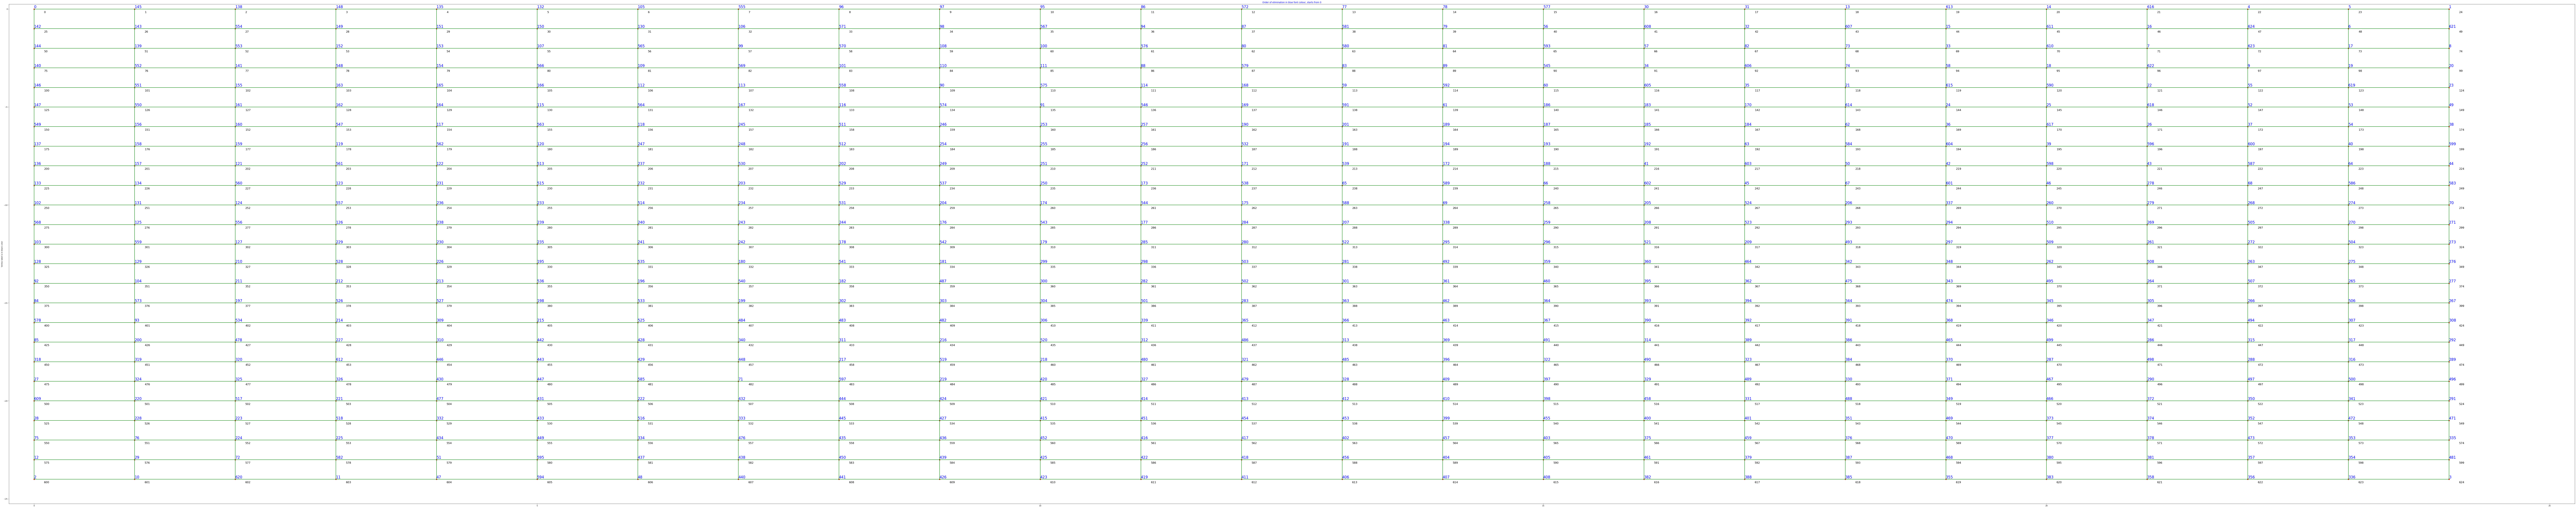

In [144]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'g-')


p=25 #grid row
q=25 #grid col
grid = grid_generator(p,q,0) #generate grid matrix
figure(num=None, figsize=(10*p, 10*np.sqrt(q)), dpi=80, facecolor='w', edgecolor='k')

#elimination ordering:
e, w, first_zero, last_zero, merge_forest, deleted = initialize(grid) #must be on global scope
elimination_ordering(grid)

grid = grid_generator(p,q,0) #re-generate grid for plot
#grid to coordinate for plot:
x = np.array(list(range(q))*p)
y = -1*np.array([[i for i in range(p)] for j in range(q)]).T.flatten()

#plot the coordinates
plt.plot(x,y, 'ro')

for i in range(grid.shape[0]):
    conn_idxs = np.where(grid[i] == 1)[0]
    for conn in conn_idxs:
        connectpoints(x,y,i,conn)

#connectpoints(x,y,0,1)
#connectpoints(x,y,1,2)

fontsize = 20

#annotate with the elimination ordering:
for i in range(len(e)):
    #annotation indexes, (x ,y) = i mod q, -1*int(i/q), where i \in e
    order = e[i]
    x_idx = order%q
    y_idx = -1*int(order/q)
    #print("order, x_idx, y_idx",order, x_idx, y_idx)
    plt.annotate(str(i), (x_idx, y_idx+0.05), fontsize=fontsize, color="blue")
#annotate label:
k = 0
for i in range(p):
    for j in range(q):
        plt.annotate(str(k), (j+0.1,-(i+0.2)), fontsize=fontsize-5)
        k+=1
        

#plt.axis('equal')
ax = plt.gca()
c = 0.25
ax.set_xlim([-c,p+c])
ax.set_ylim([-c-q,c])
plt.title("Order of elimination in blue font colour, starts from 0", color="blue")
ax.set_ylabel("Vertex label is in black color")
plt.show()

p,q,k 2 4 0
p,q,k 2 4 0


C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in double_scalars


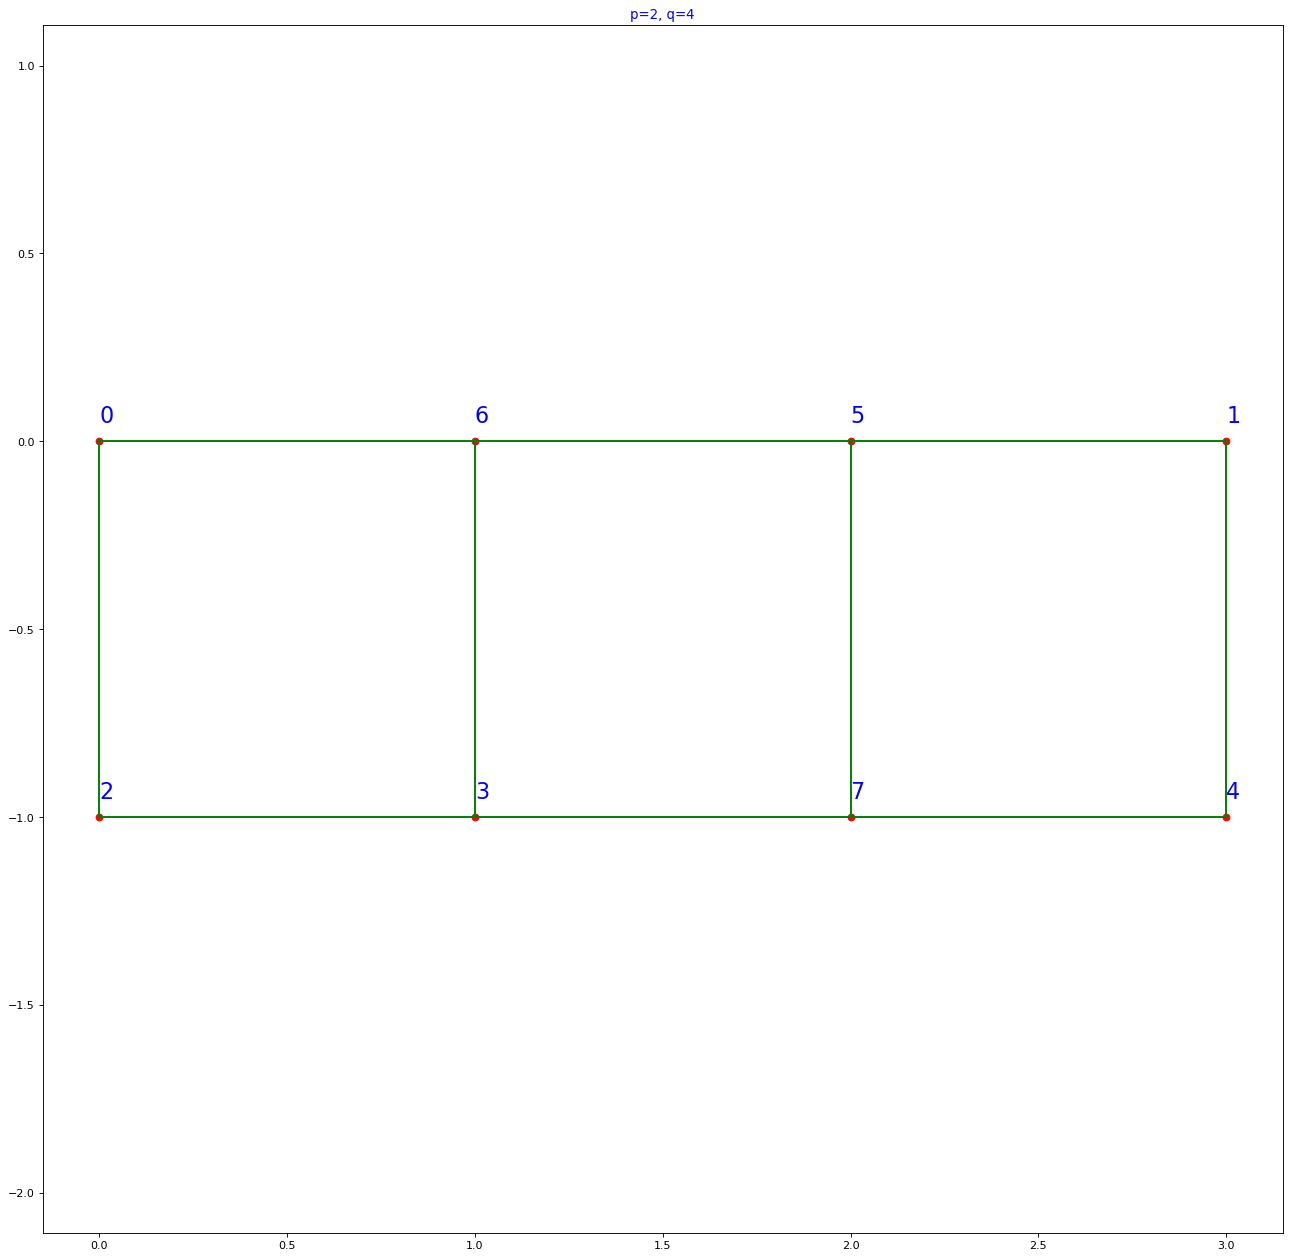

p,q,k 5 25 0
stage iteration: 0
stage iteration: 1
stage iteration: 2
stage iteration: 3
stage iteration: 4
stage iteration: 5
stage iteration: 6
stage iteration: 7
stage iteration: 8
stage iteration: 9
p,q,k 5 25 0


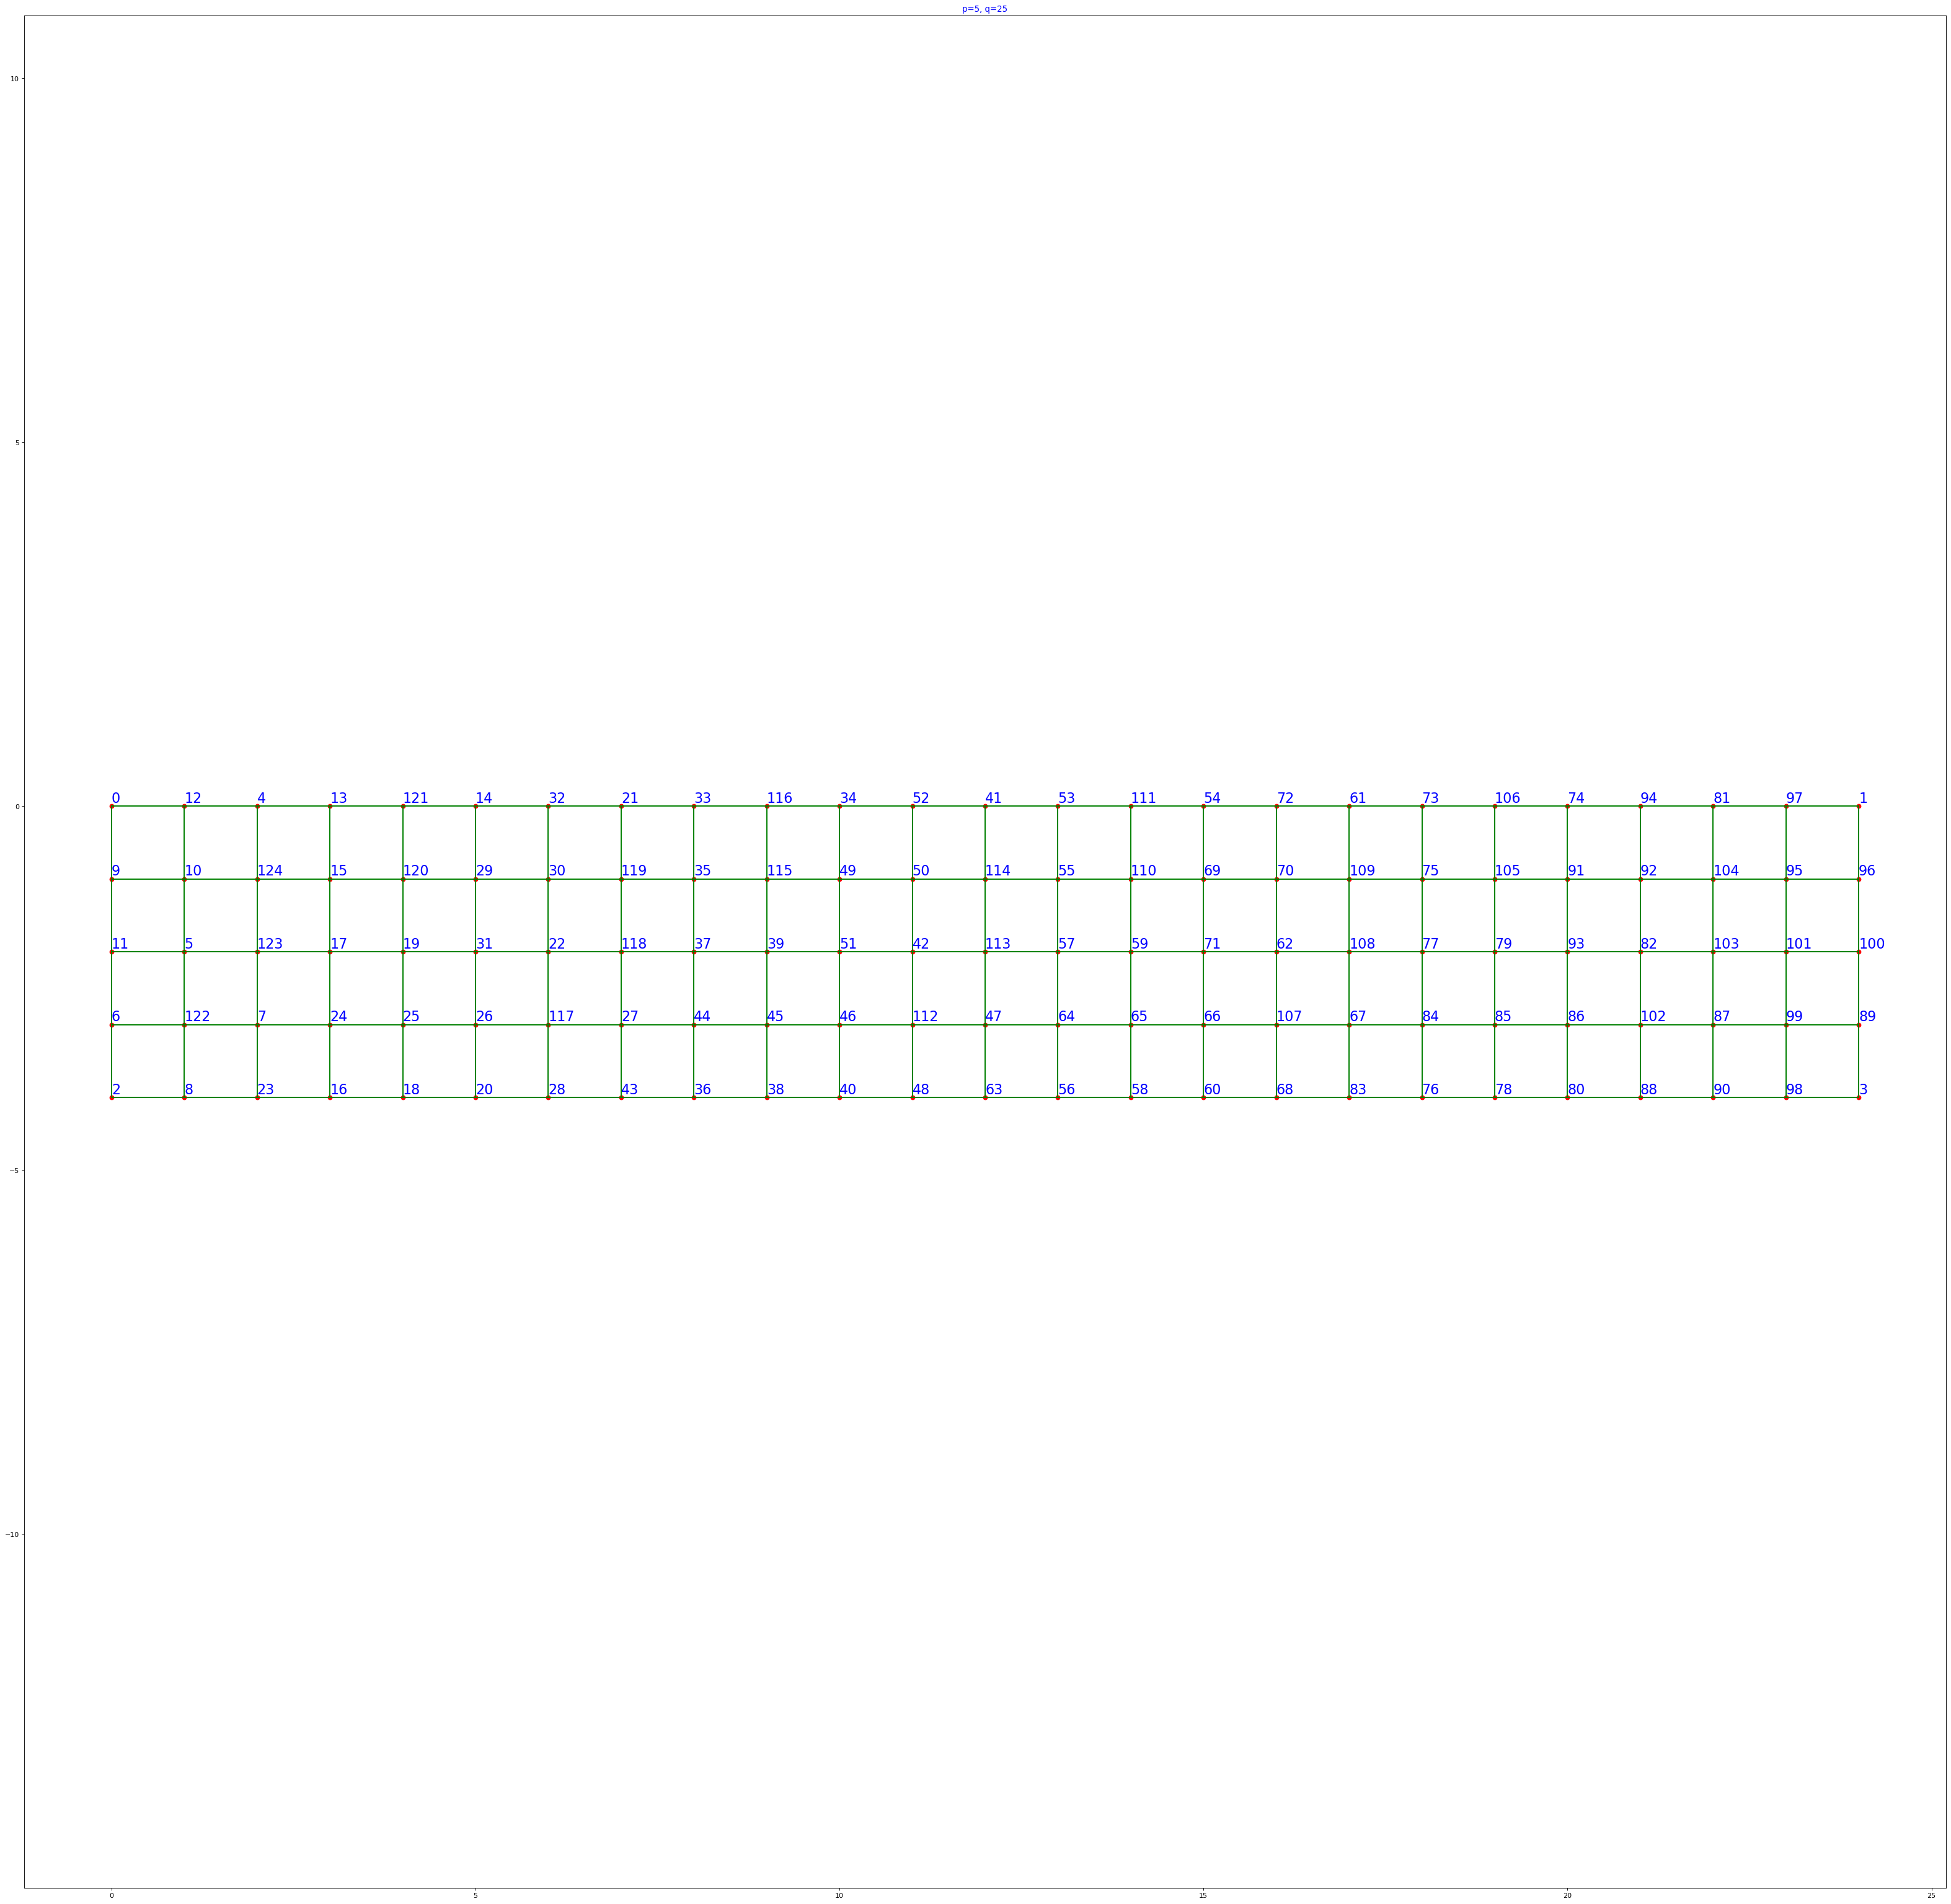

p,q,k 10 100 0
stage iteration: 0
stage iteration: 1


KeyboardInterrupt: 

<Figure size 8000x8000 with 0 Axes>

In [139]:
'''multiple grids'''
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fontsize = 20



def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'g-')

ps = [2,5,10] #list of grid rows
for p in ps:
    q=p**2 #grid col
    figure(num=None, figsize=(10*p, 10*np.sqrt(q)), dpi=80, facecolor='w', edgecolor='k')
    grid = grid_generator(p,q,0) #generate grid matrix

    #elimination ordering:
    e, w, first_zero, last_zero, merge_forest, deleted = initialize(grid) #must be on global scope
    elimination_ordering(grid)

    grid = grid_generator(p,q,0) #re-generate grid for plot
    #grid to coordinate for plot:
    x = np.array(list(range(q))*p)
    y = -1*np.array([[i for i in range(p)] for j in range(q)]).T.flatten()

    #plot the coordinates
    plt.plot(x,y, 'ro')

    for i in range(grid.shape[0]):
        conn_idxs = np.where(grid[i] == 1)[0]
        for conn in conn_idxs:
            connectpoints(x,y,i,conn)

    #connectpoints(x,y,0,1)
    #connectpoints(x,y,1,2)


    #annotate with the elimination ordering:
    for i in range(len(e)):
        #annotation indexes, (x ,y) = i mod q, -1*int(i/q), where i \in e
        order = e[i]
        x_idx = order%q
        y_idx = -1*int(order/q)
        #print("order, x_idx, y_idx",order, x_idx, y_idx)
        plt.annotate(str(i), (x_idx, y_idx+0.05), fontsize=fontsize, color="blue")
    #annotate label:
    '''k = 0
    for i in range(p):
        for j in range(q):
            plt.annotate(str(k), (j+0.1,-(i+0.2)), fontsize=fontsize-5)
            k+=1'''


    plt.axis('equal')
    c = 0.25
    #ax = plt.gca()
    #ax.set_xlim([-c,p+c])
    #ax.set_ylim([-c-q,c])
    plt.title("p="+str(p)+", q="+str(q), color="blue")
    plt.show()

In [226]:
'''print as ascii table'''
import elimination_ordering as eo
ps = [5,25,2,5]
qs = [5,25,4,25]
data = {
    "p": [],
    "q": [],
    "e_order": [],
    "place_loc": [],
    "round": []
       }

for h in range(len(ps)):
    grid = eo.grid_generator(ps[h], qs[h], 0)
    EO_obj = eo.elimination_ordering_class(grid, visualization=True)
    e = EO_obj.elimination_ordering(grid)
    print(e, EO_obj.place_loc, EO_obj.rounds_e)
    A = np.array([["0"*10]*qs[h]]*ps[h]) #length of string equals to 10 for each element of the matrix
    for i in range(e.shape[0]):
        order = e[i]
        x_idx = order%qs[h]
        y_idx = int(order/qs[h])
        sign = "+" if EO_obj.place_loc[i] == 0 else "-"
        A[y_idx][x_idx] = str(int(EO_obj.rounds_e[i]))+"_"+sign+str(i) #fill by "<round>_<sign of stage><elimination order>"
    
    #save calculation to file:
    data["p"].append(ps[h]); data["q"].append(qs[h]); data["e_order"].append(e); 
    data["place_loc"].append(EO_obj.place_loc); data["round"].append(EO_obj.rounds_e)
    with open("matrices/grid/grid_data_25022021.pr.p", 'wb') as fp:
        pickle.dump(data, fp)
    
    np.savetxt('documentation/grid_'+str(ps[h])+'_'+str(qs[h])+'.csv',A,fmt='%10s', delimiter=' ')

p,q,k 5 5 0
25
stage iteration: 0
stage iteration: 1
[ 0  4 20 24  2 11 15 17 21 19 22  5  6 10  1  8  9  3 23 18 14 13 16 12
  7] [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1. -1.  0.  0. -1.  0.
  0.  0.  0.  0.  0.  0.  0.] [0. 1. 1. 2. 0. 1. 1. 0. 2. 2. 1. 1. 0. 1. 2. 1. 0. 1. 2. 1. 0. 1. 1. 2.
 0.]
p,q,k 25 25 0
625
stage iteration: 0
stage iteration: 1
stage iteration: 2
stage iteration: 3
stage iteration: 4
stage iteration: 5
stage iteration: 6
stage iteration: 7
stage iteration: 8
stage iteration: 9
stage iteration: 10
stage iteration: 11
stage iteration: 12
stage iteration: 13
stage iteration: 14
stage iteration: 15
stage iteration: 16
stage iteration: 17
stage iteration: 18
stage iteration: 19
stage iteration: 20
stage iteration: 21
stage iteration: 22
stage iteration: 23
stage iteration: 24
stage iteration: 25
stage iteration: 26
stage iteration: 27
stage iteration: 28
[  0  24 600 624  22  23  48  71  74  97 601 603 575  18  20  44  46  73
  95  98  99 118 121 124 14

stage iteration: 0
stage iteration: 1
stage iteration: 2
stage iteration: 3
stage iteration: 4
stage iteration: 5
stage iteration: 6
stage iteration: 7
stage iteration: 8
stage iteration: 9
[  0  24 100 124   2  51  75  77 101  25  26  50   1   3   5  28 103  53
 104  54 105   7  56 102  78  79  80  82 106  30  31  55   6   8  10  33
 108  58 109  59 110  12  61 107  83  84  85  87 111  35  36  60  11  13
  15  38 113  63 114  64 115  17  66 112  88  89  90  92 116  40  41  65
  16  18  20  43 118  68 119  69 120  22  71 117  93  94  95  97 121  99
 122  45  46  70  21  48  49  23 123  98  74  73  96  72  47  44  19  91
  67  42  39  14  86  62  37  34   9  81  57  32  29   4  76  52  27] [ 0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.
  0. -1.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0. -1.  0. -1.  0.
  0. -1.  0. -1.  0.  0. -1.  0. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0.
  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.
 -1. -1.  